# Michelin Rated Restaurants in France - Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Visualisation functions
from Functions.functions_visualisation import (dataframe_info, filter_dataframe, top_geo_restaurants, 
                                               plot_choropleth, plot_multi_choropleth, plot_area_info)

In [3]:
# Analysis functions
from Functions.functions_analysis import (plot_high_correlations, print_overview_stats, plot_boxplots, 
                                          find_extreme_departments, get_random_restaurants, display_restaurants,
                                          plot_side_by_side)

----
## We load in the department and *arrondissement* GeoJSON data

In [4]:
# Load GeoJSON departmental data
departments = gpd.read_file("../../data/France/department_restaurants.geojson")
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)', 'locations', 'geometry']


In [5]:
# For pair plots we remove the individual 'star' counts and drop least interesting columns for brevity
dept_short = departments.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star', 'starred_restaurants',
                                       'municipal_population', 'GDP_millions(€)', 'area(sq_km)'])

In [6]:
dataframe_info(dept_short)

GeoDataFrame.
Unique Regions: 13
Unique Departments: 96

Shape: (96, 12)


code department          capital                region  total_stars  \
0   01        Ain  Bourg-en-Bresse  Auvergne-Rhône-Alpes            7   
1   02      Aisne             Laon       Hauts-de-France            0   
2   03     Allier          Moulins  Auvergne-Rhône-Alpes            2   

   GDP_per_capita(€)  poverty_rate(%)  average_annual_unemployment_rate(%)  \
0           25425.63             10.5                                  5.5   
1           22699.26             18.0                                 10.5   
2           24667.13             15.3                                  7.7   

   average_net_hourly_wage(€)  population_density(inhabitants/sq_km)  \
0                       15.34                                  114.2   
1                       13.92                                   71.9   
2                       13.63                                   45.7   

                                           locations  \
0  {'Bib': [[46.30794, 4.92875], [46.3846303, 5.3...   
1     {'Bib': None, '1': None, '2': None, '3': None}   
2  {'Bib': [[46.2356555, 3.4258809], [46.1248938,...   

                                            geometry  
0  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
1  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
2  POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...

----

In [7]:
# Load GeoJSON arrondissement data
arrondissements = gpd.read_file("../../data/France/arrondissement_restaurants.geojson")
print(arrondissements.columns.tolist())

['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'locations', 'geometry']


In [8]:
# For pair plots we remove the individual 'star' counts and drop least interesting columns for brevity
arron_short = arrondissements.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star',
                                            'starred_restaurants', 'municipal_population'])

In [9]:
dataframe_info(arron_short)

GeoDataFrame.
Unique Regions: 13
Unique Departments: 96
Unique Arrondissements: 320

Shape: (320, 12)


code   arrondissement department_num department          capital  \
0  01001           Belley             01        Ain  Bourg-en-Bresse   
1  01002  Bourg-en-Bresse             01        Ain  Bourg-en-Bresse   
2  01003              Gex             01        Ain  Bourg-en-Bresse   

                 region  total_stars  population_density(inhabitants/sq_km)  \
0  Auvergne-Rhône-Alpes            1                                   77.9   
1  Auvergne-Rhône-Alpes            5                                  118.4   
2  Auvergne-Rhône-Alpes            1                                  247.8   

   poverty_rate(%)  average_net_hourly_wage(€)  \
0             10.2                       15.30   
1              8.8                       15.65   
2             12.4                       15.32   

                                           locations  \
0  {'1': [[46.0070045, 5.3605085]], '2': None, '3...   
1  {'1': [[46.4340961, 4.9390332], [46.2987913, 4...   
2  {'1': [[46.3626315, 6.0258533]], '2': None, '3...   

                                            geometry  
0  POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...  
1  POLYGON ((4.98022 46.51520, 4.98355 46.51539, ...  
2  POLYGON ((6.06401 46.41623, 6.06730 46.41494, ...

----
&nbsp;
# Analysis at Regional Level

Focus on mainland France and therefore Corsica is dropped

In [10]:
regions = dept_short.region.unique().tolist()
regions.remove("Corse")
print(f"Unique Regions:\n{regions}")

Unique Regions:
['Auvergne-Rhône-Alpes', 'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Occitanie', 'Normandie', 'Nouvelle-Aquitaine', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Bretagne', 'Pays de la Loire', 'Île-de-France']


In [11]:
print(dept_short.columns.tolist())

['code', 'department', 'capital', 'region', 'total_stars', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'population_density(inhabitants/sq_km)', 'locations', 'geometry']


In [12]:
column_dictionary = {'total_stars': 'michelin_stars',
                    'GDP_per_capita(€)': 'per_capita_GDP',
                    'poverty_rate(%)': 'poverty_rate',
                    'average_annual_unemployment_rate(%)': 'unemployment_rate',
                    'average_net_hourly_wage(€)': 'net_wage',
                    'population_density(inhabitants/sq_km)': 'pop_density',
                    }

Renaming columns for clarity and concise visualization purposes.

In [13]:
# Departments
dept_short.rename(columns=column_dictionary, inplace=True)
departments.rename(columns=column_dictionary, inplace=True)

In [14]:
# Arrondissements
arron_short.rename(columns=column_dictionary, inplace=True)
arrondissements.rename(columns=column_dictionary, inplace=True)

----
&nbsp;
## Partition data into Northern/Southern France

In [15]:
south_dept = filter_dataframe(dept_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
south_arron = filter_dataframe(arron_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])

In [16]:
# Finding northern regions
s_regions = set(south_dept.region.unique().tolist())
all_regions = set(regions)
n_regions = list(all_regions - s_regions)
print(n_regions)

['Île-de-France', 'Normandie', 'Bourgogne-Franche-Comté', 'Pays de la Loire', 'Grand Est', 'Bretagne', 'Centre-Val de Loire', 'Hauts-de-France']


In [17]:
# We exclude Paris
no_paris = filter_dataframe(dept_short, exclude_departments='Paris')

In [18]:
north = filter_dataframe(dept_short, regions=n_regions)
north_no_paris = filter_dataframe(no_paris, regions=n_regions)

`north` & `north_no_paris` are useful DataFrames for further analysis

----
&nbsp;
# Narrowing scope to Southern France

## Pair Plots

We seek an overview of relationships between multiple numerical variables

Departments: 43


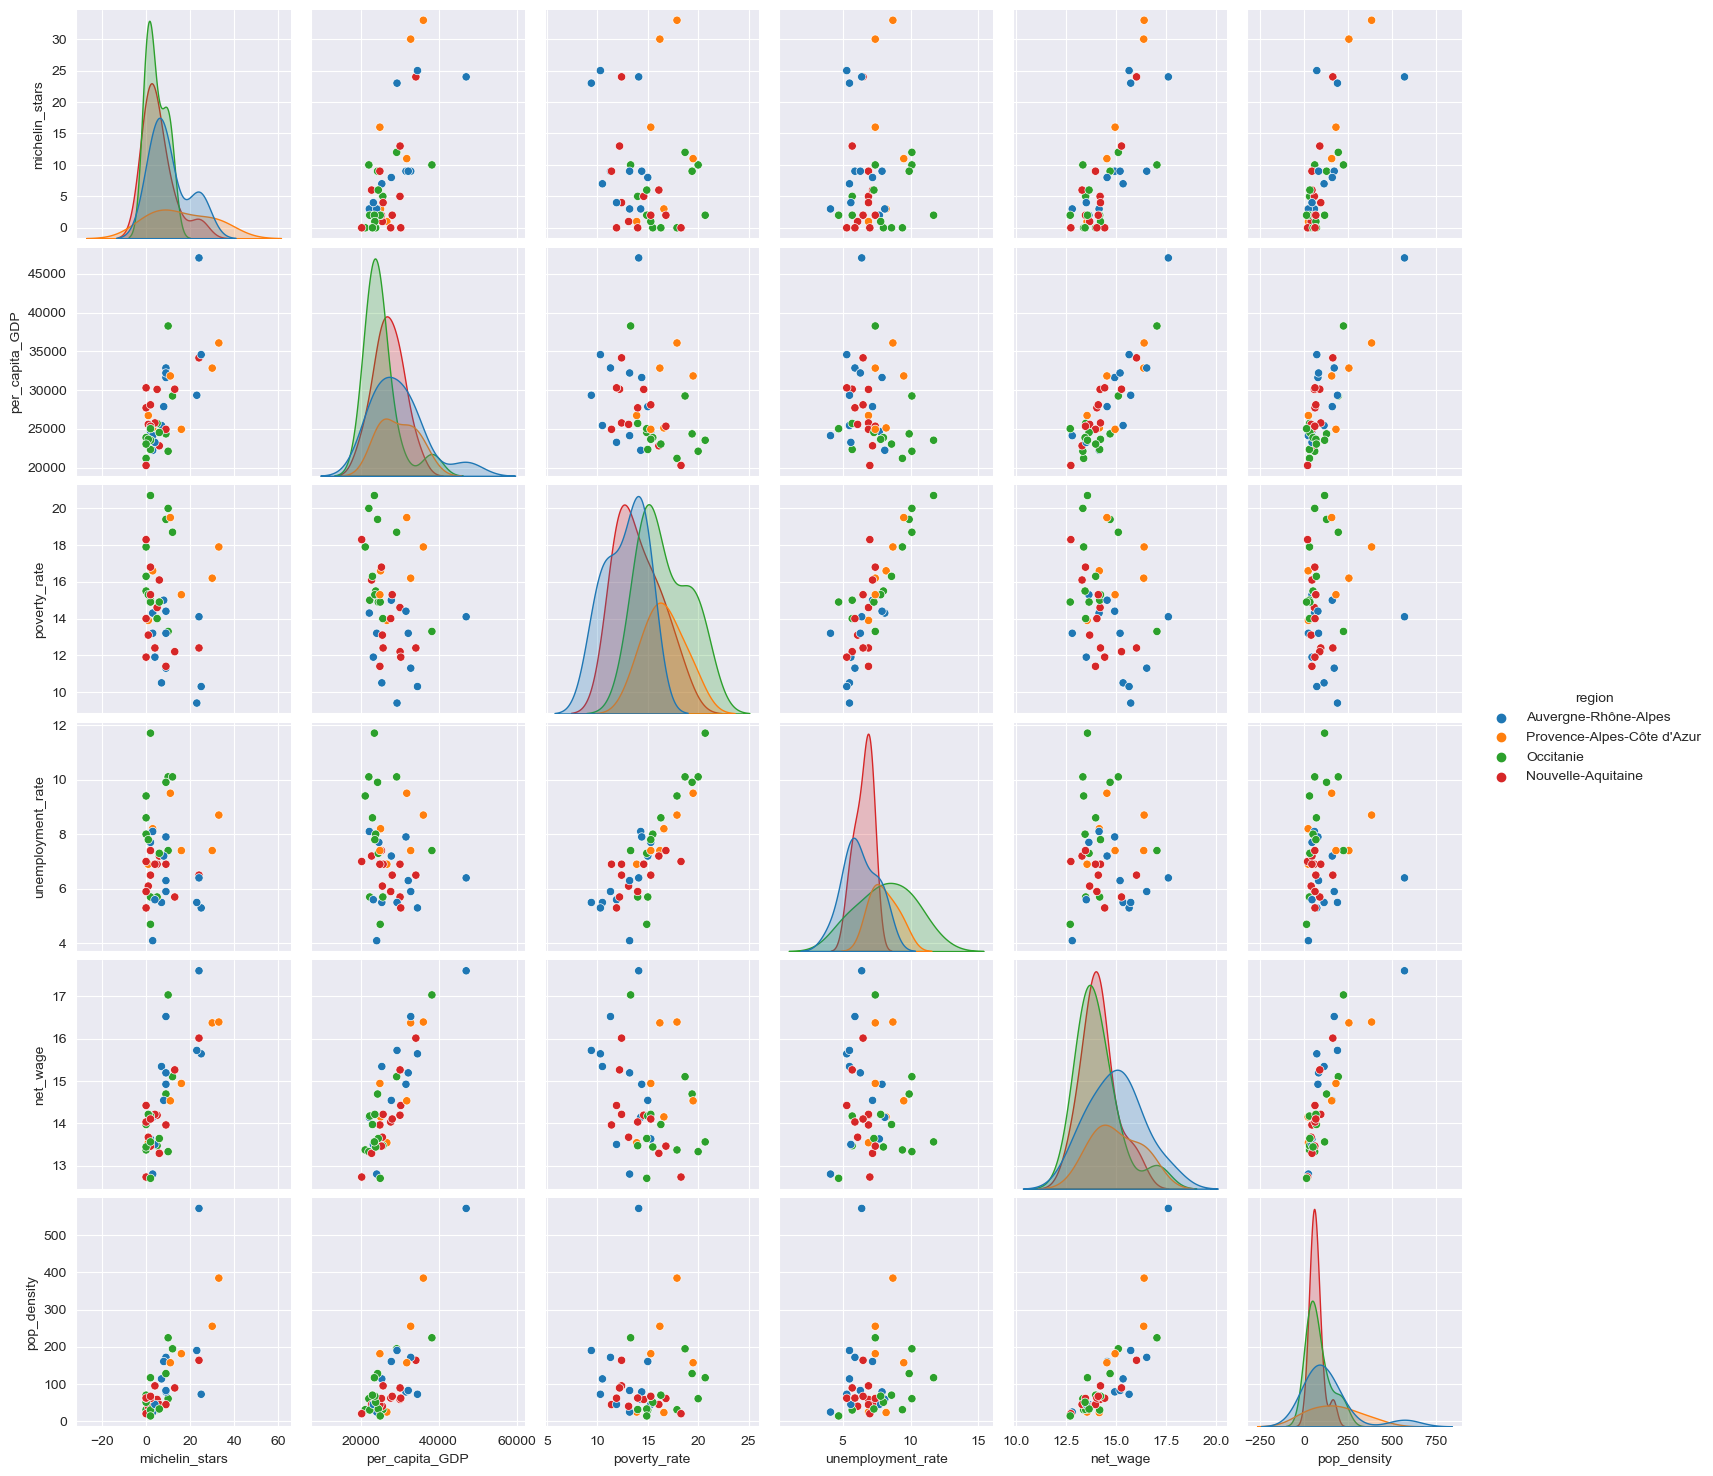

In [19]:
print(f"Departments: {south_dept.department.nunique()}")
sns.pairplot(south_dept, hue='region')

- *Auvergne-Rhône-Alpes* and *Provence-Alpes-Côte d'Azur* regions are prominently represented by five to six departments. These departments notably cluster towards the upper end in `michelin_stars` across most variable distributions. In contrast, departments from the *Occitanie* region tend to cluster towards the lower spectrum for `michelin_stars`
&nbsp;
- *Occitanie* features prominently on the higher end of the `poverty_rate` and `unemployment_rate` scales. While these patterns are evident, pinpointing whether the same departments persistently appear in these clusters across all variables would require a closer examination.
&nbsp;
- *Provence-Alpes-Côte d'Azur* stands out with the broadest spread in individual variable distributions, indicating a diverse range of values within this region.

While these patterns provide valuable insights, a deeper validation at the regional level is essential to confirm these preliminary findings.

We explore a pairplot at the *arrondissement* level. We are not in possession of `per_capita_GDP` or `unemployment_rate` data at this level of granularity

Arrondissements: 134


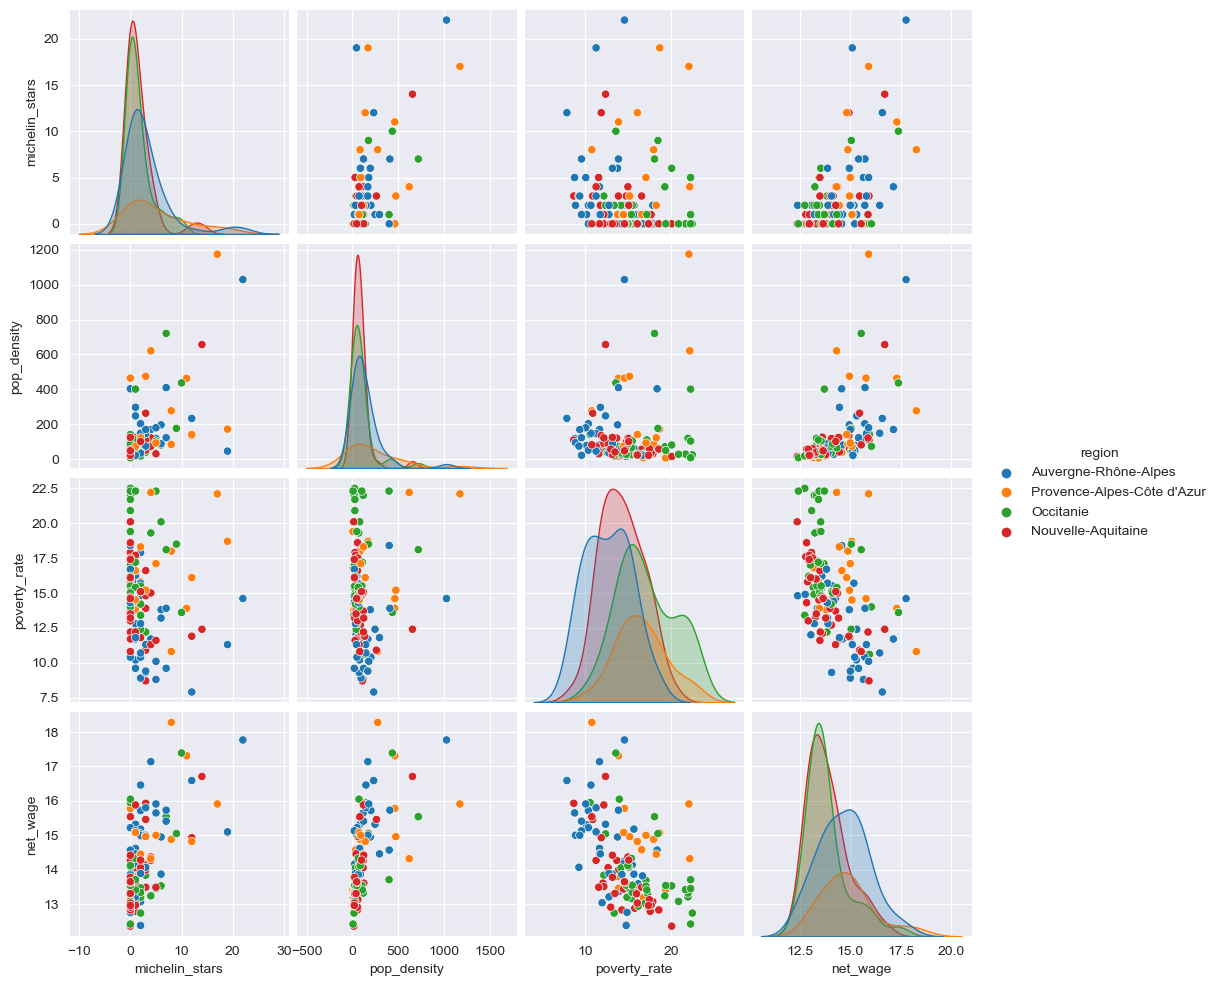

In [20]:
print(f"Arrondissements: {south_arron.arrondissement.nunique()}")
sns.pairplot(south_arron, hue='region')

There appears to be a bi-modal `poverty_rate` distribution for *Occitanie* which suggests there are a number of arrondissements with a relatively high poverty rate.

----
&nbsp;
## Heatmaps

Visualising pairwise correlations above/below a certain threshold

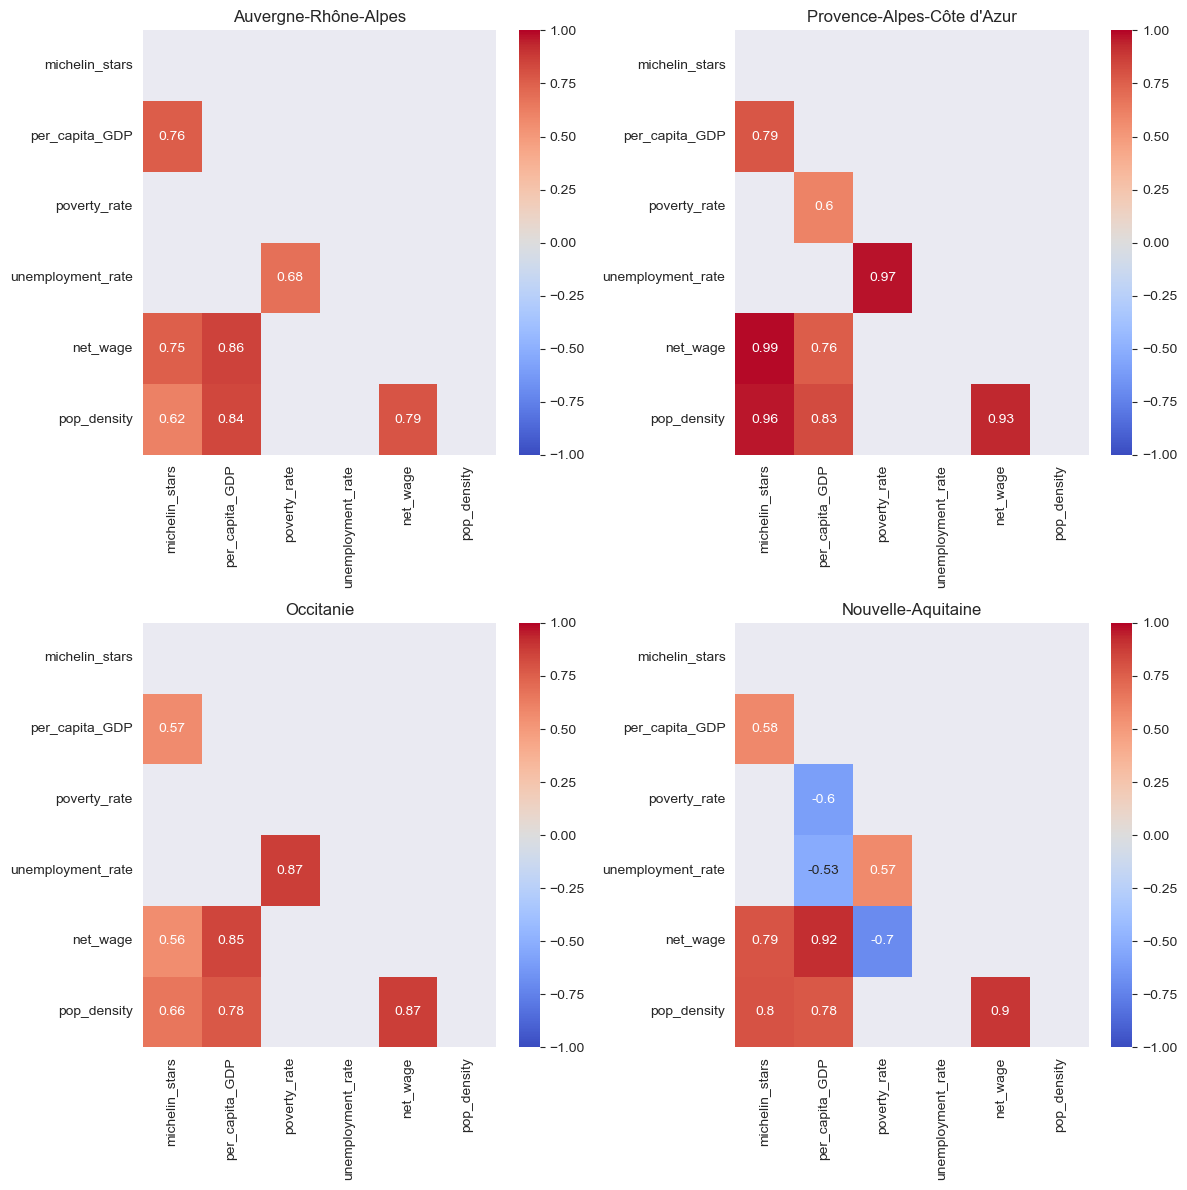

In [21]:
# We plot the correlation coefficients above a certain threshold
# I define my threshold for 'moderate correlation'
south_corr = plot_high_correlations(south_dept, level='regional', threshold=0.5)

Table of how we'll interpret Pearson's coefficient $r$ in the above heatmap
&nbsp;

| Range of $r$ | Absolute Value | Interpretation          |
|:------------:|:--------------:|:-----------------------:|
|  0.9 to 1.0  |   0.9 to 1.0   | Very Strong Correlation|
|  0.7 to 0.9  |   0.7 to 0.9   | Strong Correlation      |
|  0.5 to 0.7  |   0.5 to 0.7   | Moderate Correlation    |
|  0.3 to 0.5  |   0.3 to 0.5   | Weak Correlation        |
|  0.0 to 0.3  |   0.0 to 0.3   | Very Weak Correlation   |
|      0       |       0        | No Correlation          |
&nbsp;
This analysis does not seek to prove anything and is exploratory in nature. It aims to reveal patterns, relationships, or anomalies that could form the basis of further investigations. 

#### *Provence-Alpes-Côte d'Azur*
- There's a moderate positive correlation between `per_capita_GDP` | `poverty_rate` which could suggest economic inequality. There are cities in this region known for luxury and tourism which can create pockets of high GDP alongside areas of poverty. 
- `unemployment_rate` | `poverty_rate` are strongly correlated which is an expected relationship.
- The high correlation between `michelin_stars` | `net_wage` (0.989997) is intriguing. Does a higher concentration of Michelin-starred restaurants influence the average net wage, or is it the other way around, where areas with higher net wages attract more high-end dining establishments?

#### *Occitanie*
- `unemployment_rate` | `poverty_rate` are strongly correlated along with `net_wage` | `per_capita_GDP`.
- the strong positive correlation between `net_wage` | `pop_density` (0.868679) suggests that areas with higher population density might offer better wage opportunities. This is an expected observation, as dense areas often have cities or business hubs.

#### *Nouvelle-Aquitaine*

- There's a moderate negative correlation between 
    - `per_capita_GDP` | `poverty_rate`,
    - `per_capita_GDP` | `unemployment_rate`
    - `net_wage` | `poverty_rate` 
which are all typical yet essential economic health pointers.
  
- `net_wage` | `per_capita_GDP` show a strong positive correlation which could hint at a more even distribution of income or a balanced economy where high GDP doesn't necessarily mean just a few pockets of wealth.


----
&nbsp;
### We investigate `population_density`, `per_capita_GDP`, `poverty_rate`, `unemployment_rate`, `net_wage` & `michelin_stars` at the departmental level across regions.

In [22]:
cols_of_interest = ['michelin_stars', 'per_capita_GDP', 'poverty_rate',
                    'unemployment_rate', 'net_wage', 'pop_density']

The following tables provide statistical summaries of various socio-economic factors for the different regions of Southern France. These statistics give us insights into the region's overall economic health and the standard of living.

In [23]:
overview = south_dept.groupby('region')[cols_of_interest].describe()
print_overview_stats(overview)

Region: Auvergne-Rhône-Alpes
----------------------------
Statistic | Michelin_stars | Per_capita_gdp | Poverty_rate | Unemployment_rate | Net_wage | Pop_density
-------------------------------------------------------------------------------------------------------
Count     | 12.00          | 12.00          | 12.00        | 12.00             | 12.00    | 12.00      
Mean      | 10.50          | 29595.04       | 12.74        | 6.29              | 14.96    | 134.99     
Std       | 8.53           | 6876.40        | 2.00         | 1.22              | 1.35     | 147.47     
Min       | 2.00           | 22224.31       | 9.40         | 4.10              | 12.80    | 25.20      
25%       | 3.75           | 24529.08       | 11.10        | 5.50              | 14.01    | 56.12      
50%       | 8.50           | 28593.16       | 13.20        | 6.10              | 15.05    | 81.15      
75%       | 12.50          | 32361.43       | 14.33        | 7.33              | 15.66    | 163.58     
Max   

##### Key Insights: 

*Auvergne-Rhône-Alpes* has the highest mean for Michelin stars, suggesting a strong gastronomic presence. Additionally, with a high GDP, this is a relatively prosperous region. The unemployment rate and poverty rate show areas of potential concern.

*Nouvelle-Aquitaine*: Interestingly, even though the GDP is less compared to Auvergne-Rhône-Alpes, the net wage seems comparable. However, the poverty rate is a bit higher.

*Occitanie* has the highest unemployment rate, which aligns with its high poverty rate. Its GDP per capita is lower than the other regions. It's Michelin presence is the lowest in the South of France. It would be interesting to explore the distribution of michelin stars.

*Provence-Alpes-Côte d'Azur*: This region has the second-highest Michelin stars on average but has fewer departments. The unemployment and poverty rates are considerable, even with a high GDP, suggesting some level of economic disparity.

#### Visualising the distribution of the above data

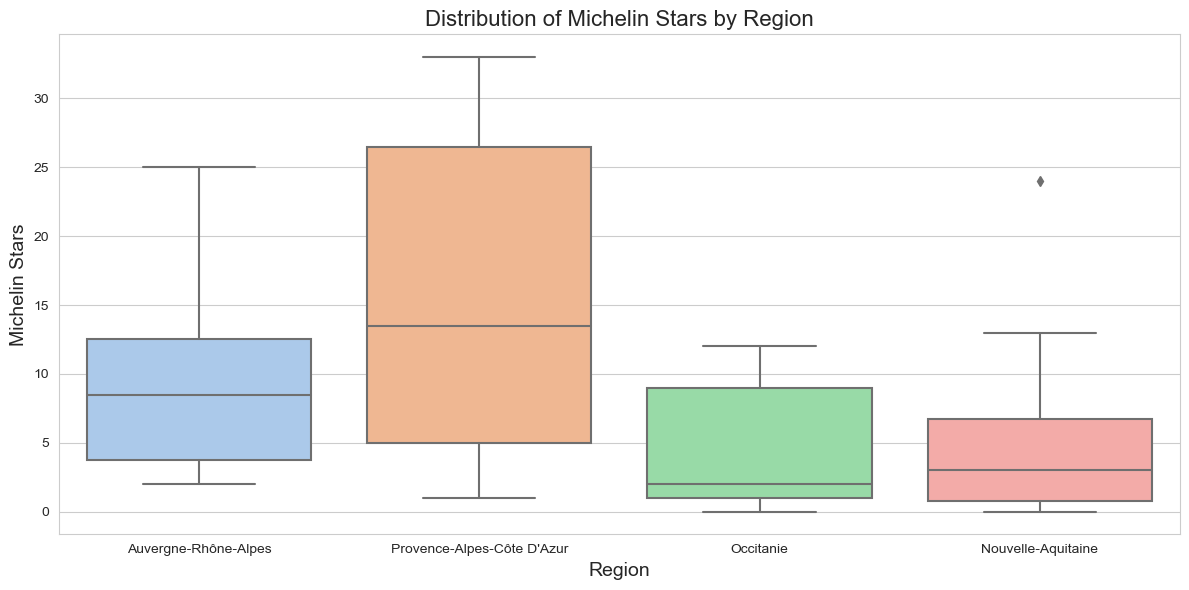

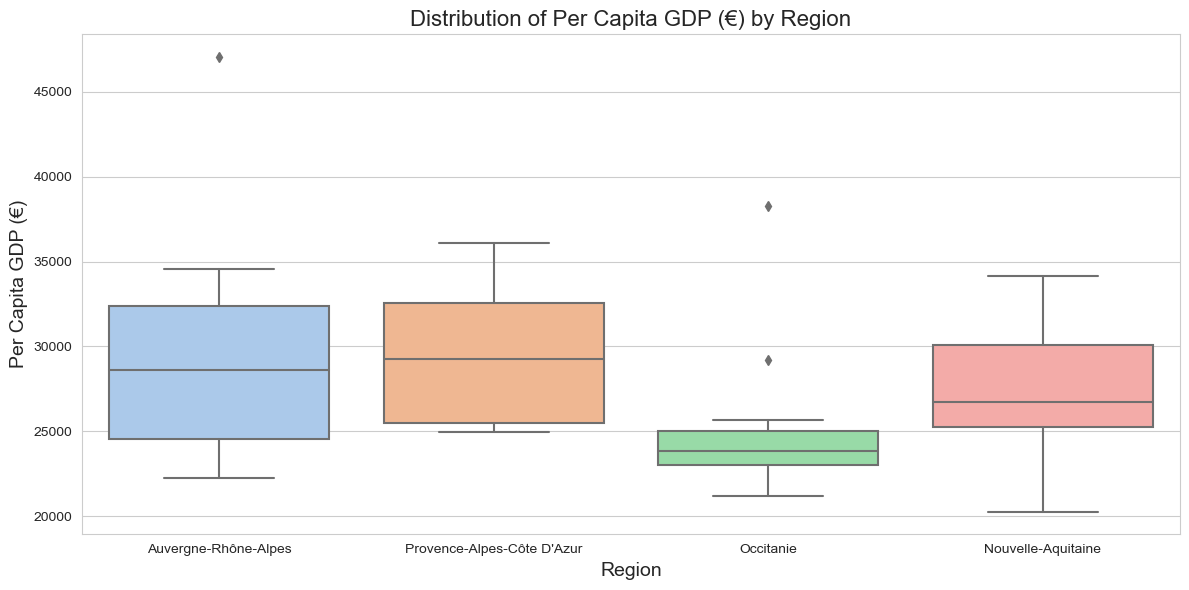

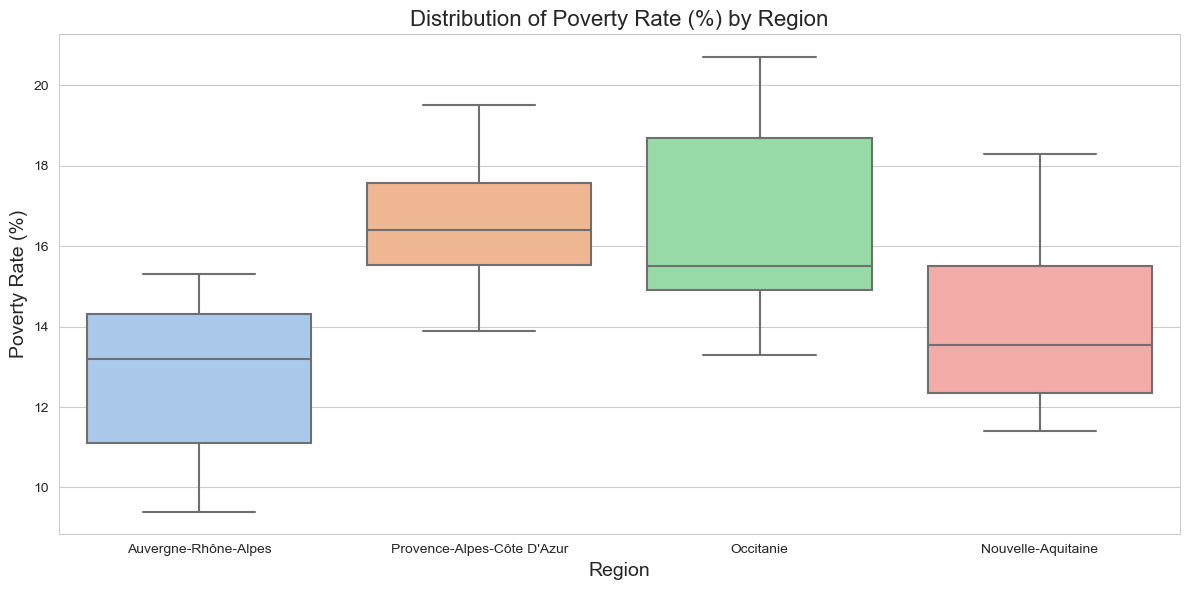

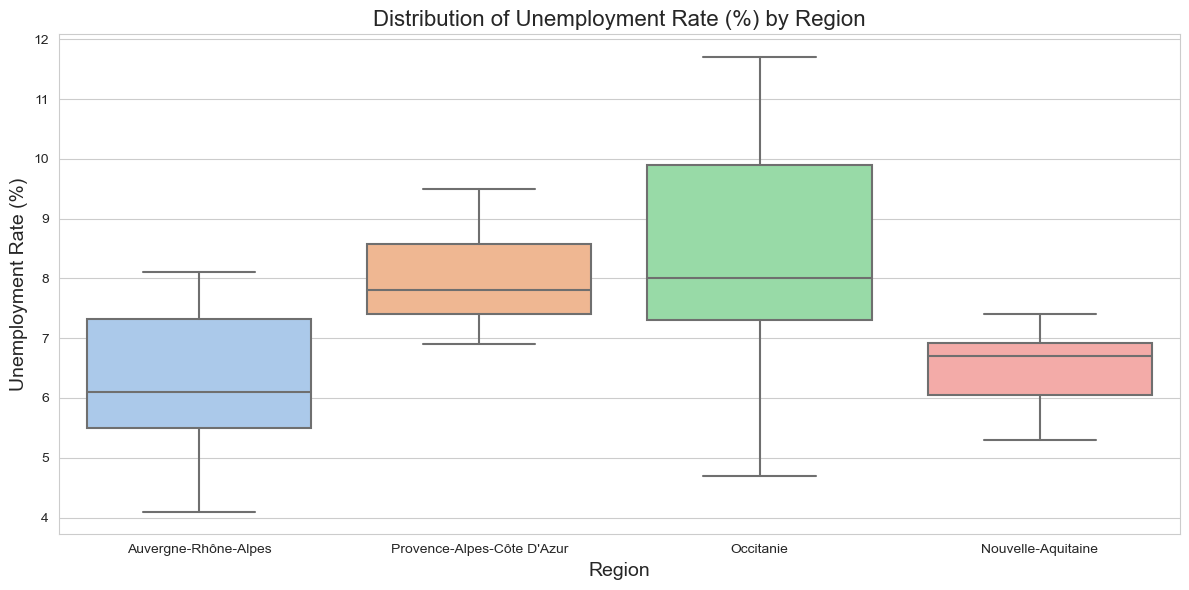

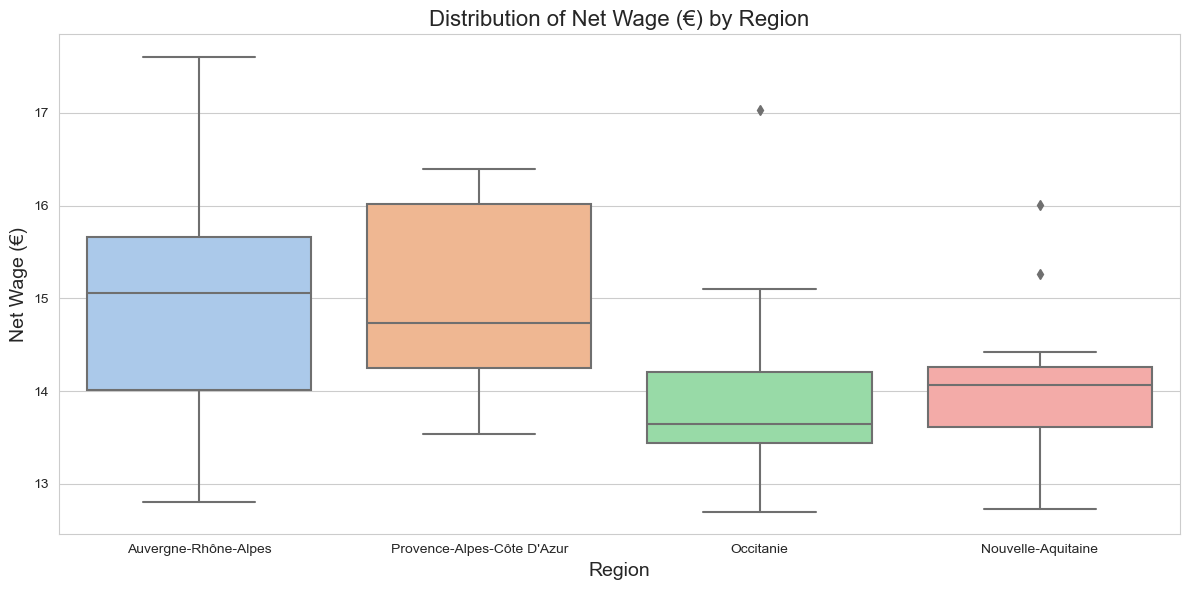

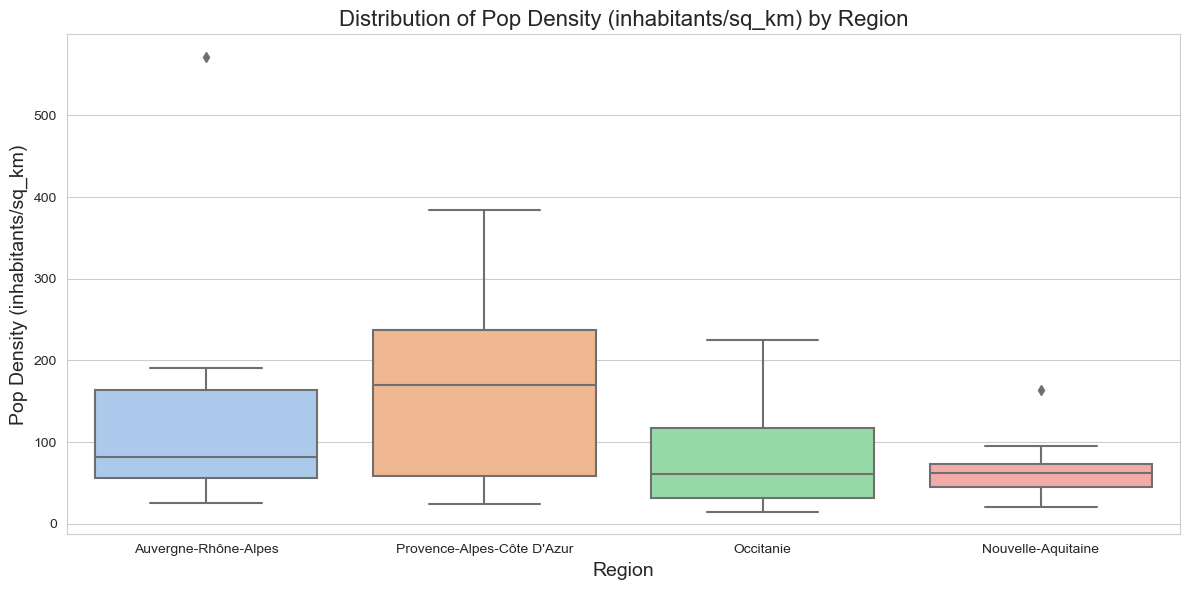

In [24]:
plot_boxplots(south_dept, cols_of_interest)

----
&nbsp;
#### `find_extreme_departments` 
function provides a granular view of metrics across different departments within each region. Specifically, it identifies which departments stand out as the highest and lowest performers for various socio-economic indicators.

In [25]:
find_extreme_departments(south_dept, cols_of_interest)

Region: Auvergne-Rhône-Alpes

michelin_stars
	Max: Savoie (73) = 25 
	Min: Allier (03) = 2 

per_capita_GDP
	Max: Rhône (69) = 47048.24 €
	Min: Ardèche (07) = 22224.31 €

poverty_rate
	Max: Allier (03) = 15.3 %
	Min: Haute-Savoie (74) = 9.4 %

unemployment_rate
	Max: Ardèche (07) = 8.1 %
	Min: Cantal (15) = 4.1 %

net_wage
	Max: Rhône (69) = 17.6 €
	Min: Cantal (15) = 12.8 €

pop_density
	Max: Rhône (69) = 571.3 inhabitants/sq_km
	Min: Cantal (15) = 25.2 inhabitants/sq_km

--------------------------------------------------
Region: Provence-Alpes-Côte d'Azur

michelin_stars
	Max: Bouches-du-Rhône (13) = 33 
	Min: Hautes-Alpes (05) = 1 

per_capita_GDP
	Max: Bouches-du-Rhône (13) = 36072.35 €
	Min: Var (83) = 24932.52 €

poverty_rate
	Max: Vaucluse (84) = 19.5 %
	Min: Hautes-Alpes (05) = 13.9 %

unemployment_rate
	Max: Vaucluse (84) = 9.5 %
	Min: Hautes-Alpes (05) = 6.9 %

net_wage
	Max: Bouches-du-Rhône (13) = 16.39 €
	Min: Hautes-Alpes (05) = 13.54 €

pop_density
	Max: Bouches-du-Rhône

## Insights from the Output:

**Michelin Stars:**

- In the Auvergne-Rhône-Alpes region, Savoie stands out with 25 Michelin stars, indicating a potential culinary tourism hotspot, whereas Allier has just 2.
- In Provence-Alpes-Côte d'Azur (PACA), Bouches-du-Rhône leads with 33 stars, while Hautes-Alpes has only 1.
- Occitanie has Hérault with 12 stars at its pinnacle and Ariège with none.

**Economic Indicators:**

- In PACA, Bouches-du-Rhône, besides its culinary accolade, also stands out with a GDP per capita of €36072.35. However, it's interesting to see that Var, another department in the same region, has the lowest GDP per capita at €24932.52.

- In Occitanie, Haute-Garonne shines with a GDP per capita of €38265.18, while Ariège trails with €21182.3.

**Social Indicators:**

- PACA showcases a noticeable range in poverty rates, with Vaucluse having a high of 19.5%, and Hautes-Alpes a relatively lower 13.9%.

- Similarly, in Occitanie, Pyrénées-Orientales has a high poverty rate of 20.7%, contrasting with Haute-Garonne's 13.3%.

To better understand these results, we find the weighted mean `poverty_rate`, `unemployment_rate` and `net_wage` across France
$$
\mathrm{Weighted \ Mean} = \frac{\sum_i (\mathrm{value}_i \times \mathrm{weight}_i)}{\sum_i \mathrm{weight}_i}
$$

In [26]:
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'michelin_stars', 'starred_restaurants', 'GDP_millions(€)', 'per_capita_GDP', 'poverty_rate', 'unemployment_rate', 'net_wage', 'municipal_population', 'pop_density', 'area(sq_km)', 'locations', 'geometry']


Paris is a significant outlier in the context of France's GDP. As the capital city, is not only the political center but also the economic and cultural hub. It houses many multinational corporations, leading institutions, and is a global city. Including Paris might make the weighted average GDP unrepresentative of the entire country due to its unique economic landscape.

In [27]:
paris = filter_dataframe(departments, departments='Paris')
print(f"GDP Paris: {paris['per_capita_GDP'].values[0]} €")

GDP Paris: 105320.08 €


In [28]:
no_paris = filter_dataframe(departments, exclude_departments='Paris')

# Exclude Paris from GDP calculation
france_GDP_no_paris = (no_paris['per_capita_GDP'] * no_paris['municipal_population']).sum() /\
                        no_paris['municipal_population'].sum()

france_GDP = (departments['per_capita_GDP'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

print(f"Weighted mean GDP per capita across France (excluding Paris): {france_GDP_no_paris:.2f}€")
print(f"Weighted mean GDP per capita across France: {france_GDP:.2f}€\n")

Weighted mean GDP per capita across France (excluding Paris): 32308.02€
Weighted mean GDP per capita across France: 34708.49€


There is approx. 7.5% increase in the weighted average `per_capita_GDP` including Paris in the calculation. This could be significant. 

**GDP per Capita as an Economic Marker**:
- Advantage: 
    - Provides a quick snapshot of an economy's health
- Limitations:
    - Doesn't account for income distribution
    - Doesn't consider informal economy
    - May not reflect actual standards of living

In [29]:
# Compute the weighted means
france_poverty = (departments['poverty_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_unemployment = (departments['unemployment_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_wage = (departments['net_wage'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()


print(f"Weighted mean poverty rate across France: {france_poverty:.2f}%")
print(f"Weighted mean unemployment rate across France: {france_unemployment:.2f}%")
print(f"Weighted mean hourly wage across France: {france_wage:.2f}€")

Weighted mean poverty rate across France: 14.43%
Weighted mean unemployment rate across France: 7.13%
Weighted mean hourly wage across France: 16.05€


- **Hourly wage**: Reflects the earning potential and can provide insights into the dominant industries or sectors in a region

- **Poverty rate**: A high value can indicate economic distress, signaling potential issues like lack of job opportunities, low wages, or other socio-economic challenges.

- **Unemployment rate**: Directly shows the health of the job market. Elevated values can be a symptom of economic issues, structural challenges, or a mismatch between available jobs and the skills of the workforce.

Examining departmental extrema, we notice *Pyrénées-Orientales* (66) in Occitanie and *Vaucluse* (84) in PACA have `poverty_rate` and `unemployment_rate` well above the national average.

#### Visualisation of these metrics across the southern regions and across all France

In [30]:
cols_of_interest = ['per_capita_GDP', 'unemployment_rate', 'poverty_rate', 'net_wage']
titles = ['GDP per capita (€)', 'Unemployment Rate (%)', 'Poverty Rate (%)', 'Hourly Net Wage (€)']

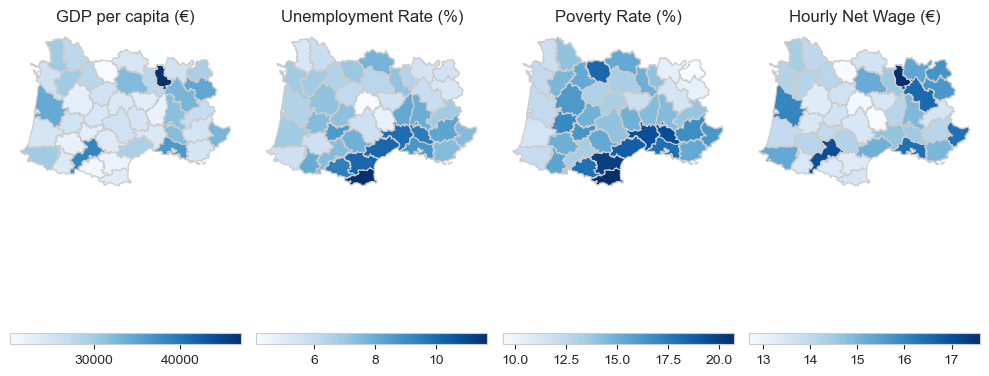

In [31]:
plot_multi_choropleth(south_dept, cols_of_interest, titles, granularity='department', show_labels=False)

Rhône (69) (with capital Lyon) has the greatest `per_capita_GDP` in the South, a relatively low `poverty_rate` & `unemployment_rate` and a relatively high `net_wage`. By these metrics, this is one of the wealthiest departments in South of France.

The departments along the Mediterranean coast (excluding 06 and 83) are some of the most poverty-stricken in the South of France.

As shown below, these departments have some of the highest `unemployment_rate` and `poverty_rate` in the whole of France.

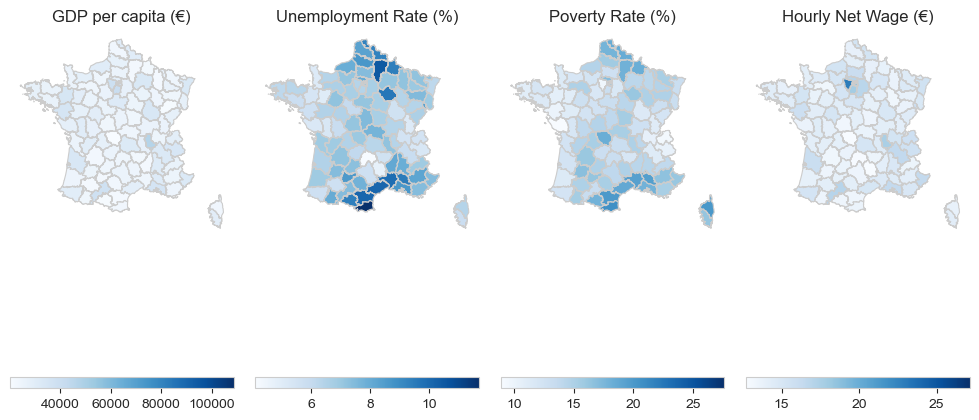

In [32]:
plot_multi_choropleth(dept_short, cols_of_interest, titles, granularity='department', show_labels=False)

----
&nbsp;
## Regional gastronomy & Michelin starred restaurants
Exploring the top 10 departments in the South of France by total Michelin stars as opposed to Michelin starred restaurants.

In [33]:
south_all_cols = filter_dataframe(departments, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
top_geo_restaurants(south_all_cols, granularity='department', top_n=10)

Top 10 departments with most Michelin-starred restaurants:


1: Department: Bouches-du-Rhône
Total Stars: 33
Total Restaurants: 25

4 ⭐⭐⭐ Restaurants
21 ⭐ Restaurants


2: Department: Alpes-Maritimes
Total Stars: 30
Total Restaurants: 24

1 ⭐⭐⭐ Restaurant
4 ⭐⭐ Restaurants
19 ⭐ Restaurants


3: Department: Savoie
Total Stars: 25
Total Restaurants: 17

2 ⭐⭐⭐ Restaurants
4 ⭐⭐ Restaurants
11 ⭐ Restaurants


4: Department: Gironde
Total Stars: 24
Total Restaurants: 19

5 ⭐⭐ Restaurants
14 ⭐ Restaurants


5: Department: Rhône
Total Stars: 24
Total Restaurants: 20

4 ⭐⭐ Restaurants
16 ⭐ Restaurants


6: Department: Haute-Savoie
Total Stars: 23
Total Restaurants: 16

2 ⭐⭐⭐ Restaurants
3 ⭐⭐ Restaurants
11 ⭐ Restaurants


7: Department: Var
Total Stars: 16
Total Restaurants: 13

1 ⭐⭐⭐ Restaurant
1 ⭐⭐ Restaurant
11 ⭐ Restaurants


8: Department: Pyrénées-Atlantiques
Total Stars: 13
Total Restaurants: 13

13 ⭐ Restaurants


9: Department: Hérault
Total Stars: 12
Total Restaurants: 12

12 ⭐ Restaur

### Economic Disparity and Gastronomy:

**Luxury Tourism and Affluence**:

- **Alpes-Maritimes (06) and Var (83)**: 
    These departments anchor the luxurious Côte d'Azur. With cities like Cannes, Antibes, Nice, and Saint-Tropez, they allure the global elite due to film festivals, yachting events, and the Riviera's glamorous appeal. The influx of high-net-worth tourists drives demand for upscale dining, leading to a surge in Michelin-starred restaurants.
&nbsp;
- **Savoie (73) and Haute-Savoie (74)**: 
    Renowned for ski resorts like Chamonix and Courchevel, their global standing and wealthy clientele account for the prevalence of Michelin-starred establishments.

**Contrasting Economic Realities**:

- **Hérault (34), Vaucluse (84), and Bouches-du-Rhône (13)**: 
    These departments, despite their Michelin recognition, face significant economic challenges.

**Tourism as a Double-Edged Sword**:
&nbsp;
Tourism can lead to economic imbalances. While certain segments (e.g., luxury hospitality) thrive, the wealth may not be evenly distributed. Tourist-centric locales might have prospering hotels and restaurants but still endure stark economic contrasts. This dynamic might elucidate the Michelin recognitions in Hérault and Vaucluse, highlighting the uneven boons of tourism.

**Conclusion**:

The juxtaposition of Michelin stars and economic disparity paints a complex portrait of the South of France. While culinary excellence can be a beacon of cultural pride and economic gain for some, it can exist concurrently with profound socioeconomic challenges


We plot the South of France by number of ⭐⭐ and ⭐⭐⭐ restaurants

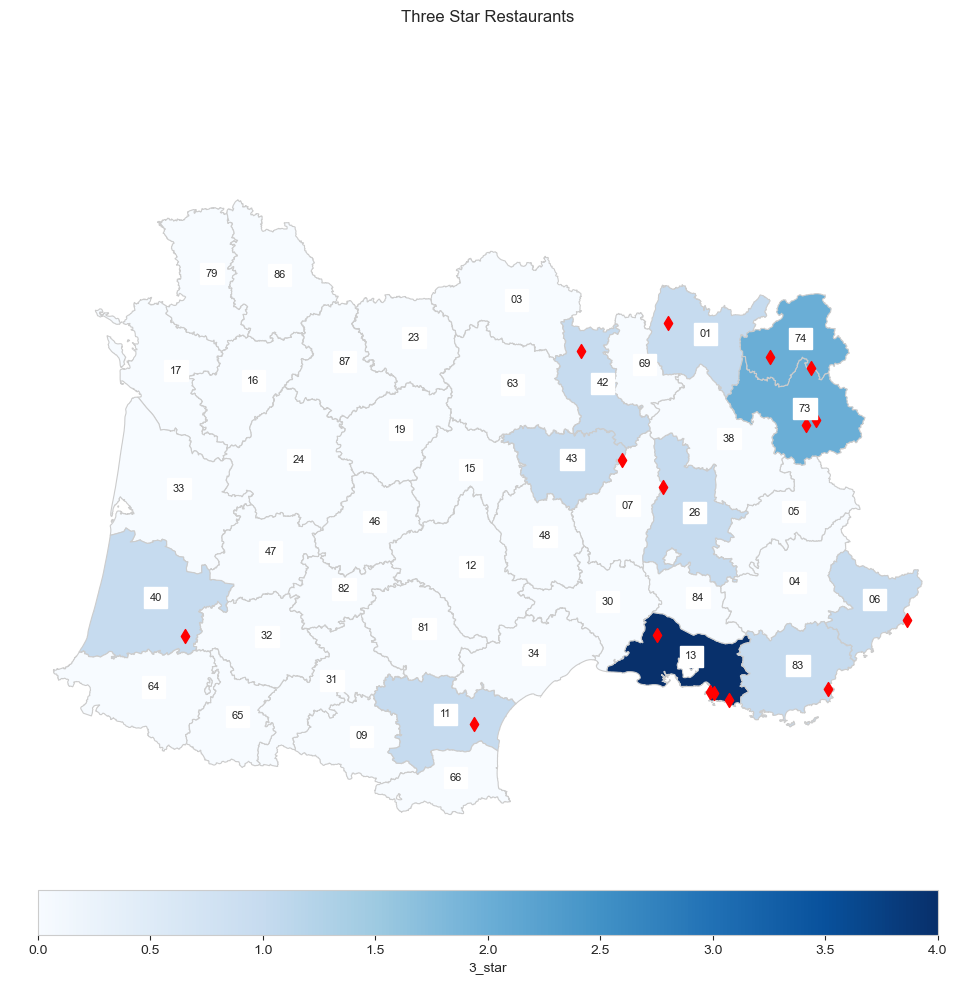

In [34]:
plot_choropleth(south_all_cols, '3_star', 'Three Star Restaurants', restaurants=True, star_rating=3, show_legend=False)

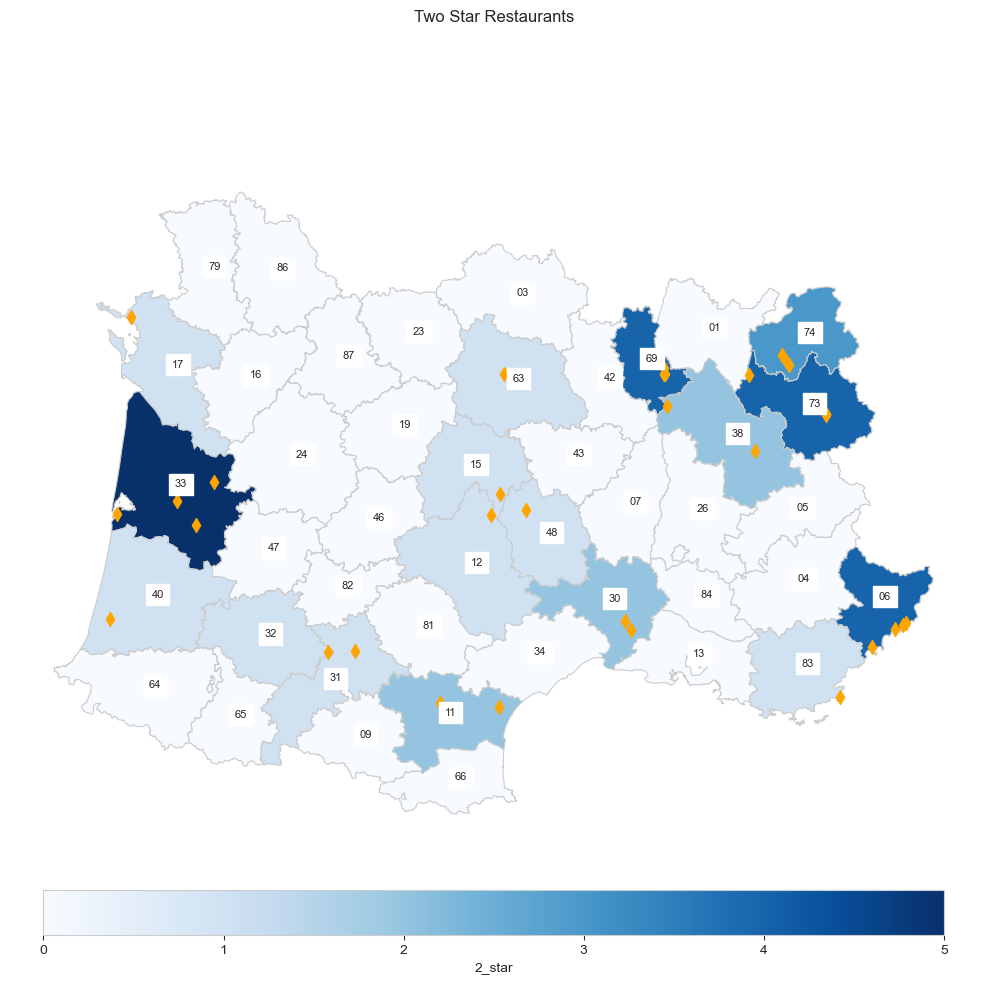

In [35]:
plot_choropleth(south_all_cols, '2_star', 'Two Star Restaurants', restaurants=True, star_rating=2, show_legend=False)

### Price

The Michelin Guide defines its restaurant price ratings in the following way;
&nbsp;

| Price Category   | Description          |
|------------------|----------------------|
| €€€€             | Spare no expense     |
| €€€              | Special occasion     |
| €€               | A moderate spend     |
| €                | On a budget          |

&nbsp;
How many starred restaurants in the South of France have a price rating below €€€?

In [38]:
france_restos = pd.read_csv("../../data/France/all_restaurants(arrondissements).csv")
south_restos = filter_dataframe(france_restos, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
print(f"South of France:\n{south_restos.shape[0]} restaurants in total (including Bibs)")

South of France:
486 restaurants in total (including Bibs)


In [39]:
# Filter out bib gourmands
starred_restos = south_restos[south_restos['stars'] != 0.5]

# Group by price rating
price_groups = starred_restos.groupby('price').size()
print(price_groups)

price
€€        3
€€€     112
€€€€    163
dtype: int64


Only three Michelin starred restaurants have a price rating of €€: "A moderate spend"

While the Michelin Guide offers a general price rating (from 'On a budget' to 'Spare no expense'), these descriptors can be subjective and may vary significantly based on an individual's perspective or the restaurants location and popularity.

To offer a more tangible insight into the price of a meal, we will select five restaurants at random in the €€€ and €€€€ category. A random seed is selected making the selection reproducible.

If available, the price reported will be a tasting menu for dinner (without drinks). If the restaurant doesn't offer a tasting menu, we report the price of a three-course menu or the price of three-courses à la carte

In [40]:
selected_restos = get_random_restaurants(south_restos, seed=45)
display_restaurants(selected_restos)

Price rating: €€€€




Price rating: €€€


#### Results

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Lalique | Bommes, 33210 | ⭐⭐ | 245 €                 |
| La Vague d'Or - Cheval Blanc St-Tropez | Saint-Tropez, 83990 | ⭐⭐⭐ | 450 €                 |
| Le Saint-Estève | Le Tholonet, 13100 | ⭐ | 190 €                 |
| Ursus | Tignes, 73320 | ⭐ | 168 €                 |
| La Table de Patrick Raingeard | Èze-Bord-de-Mer, 06360 | ⭐ | 250 €                 |

**Price rating: €€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Restaurant de la Loire | Pouilly-sous-Charlieu, 42720 | ⭐ | 92 €                  |
| Le Passe Temps | Lyon, 69006 | ⭐ | 105 €                 |
| Les Clefs d'Argent | Mont-de-Marsan, 40000 | ⭐ | 97 €                  |
| Auberge du Cep | Fleurie, 69820 | ⭐ | 70 €                  |
| Villa de l'Étang Blanc | Seignosse, 40510 | ⭐ | 90 €                  |


There's one three star restaurant in the random selection and the price difference is vast!

Considering the ⭐⭐ restaurant *Lalique* (33), there is not a vast difference in price between the ⭐ restaurants in the €€€€ price category.
 
We randomly select ⭐⭐ & ⭐⭐⭐ restaurants below to get some idea of the price spread. 

In [41]:
three_stars = get_random_restaurants(south_restos, star_rating=3, seed=45)
display_restaurants(three_stars)

Price rating: €€€€


#### Three-Star Michelin Restaurants

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| L'Oustau de Baumanière | Les Baux-de-Provence, 13520 | ⭐⭐⭐ | 330 €                 |
| Le 1947 à Cheval Blanc | Courchevel, 73120 | ⭐⭐⭐ | 415 €                 |
| La Villa Madie | Cassis, 13260 | ⭐⭐⭐ | 350 €                 |
| Auberge du Vieux Puits | Fontjoncouse, 11360 | ⭐⭐⭐ | 290 €                 |
| Pic | Valence, 26000 | ⭐⭐⭐ | 380 €                 |


In [42]:
two_stars = get_random_restaurants(south_restos, star_rating=2, seed=45)
display_restaurants(two_stars)

Price rating: €€€€


#### Two-Star Michelin Restaurants

**Price rating: €€€€**

| Restaurant | Location | Star Rating | Price of Tasting Menu |
|------------|----------|-------------|-----------------------|
| Le Pressoir d'Argent - Gordon Ramsay | Bordeaux, 33000 | ⭐⭐ | 235 €                 |
| La Pyramide - Patrick Henriroux | Vienne, 38200 | ⭐⭐ | 206 €                 |
| La Table Lionel Giraud | Narbonne, 11100 | ⭐⭐ | 220 €                 |
| Le Neuvième Art | Lyon, 69006 | ⭐⭐ | 220 €                 |
| La Table de Franck Putelat | Carcassonne, 11000 | ⭐⭐ | 235 €                 |


Given the prices of ⭐⭐⭐ and ⭐⭐ Michelin restaurants, we can draw several insights:

**Price Tier Distinction**: 
All of the restaurants listed, whether they have three stars or two, fall under the €€€€ price rating, reinforcing the notion that Michelin-starred dining is often an upscale experience. This could be expected given the high standards and the associated costs of maintaining such a status.

**Three Stars vs. Two Stars**: 
The price range for the three-star restaurants is broader, ranging from 290 € to 450 € for a tasting menu. This can be attributed to the uniqueness of each restaurant's offerings and perhaps the location, expertise of the chef, and the ingredients used. On the other hand, two-star restaurants have a more narrow price range (206 € to 235 €), suggesting some consistency in pricing in this category.

**Location**: 
Locations like Courchevel and Saint-Tropez are known to be luxurious destinations, which could play a role in the pricing. The presence of Michelin-starred restaurants in these areas may reflect the high spending capacity of the clientele frequenting these regions.
We randomly selected two restaurants of the *Cheval Blanc* group (In France, there is a third in Paris). Both these restaurants break the 400€ mark.

**The Two-Star Conundrum**: 
Two-star restaurants often have chefs and teams that are pushing boundaries, aiming for that elusive third star. This drive can result in innovative menus and exceptional quality, potentially offering diners a near three-star experience at slightly reduced prices.
In 2018 I visited  ⭐⭐ [*Mirazur*](https://www.mirazur.fr) in Menton (06), the tasting menu was 250€. In 2019, it was awarded  ⭐⭐⭐, the tasting menu is currently 450€.

**Conclusion**
While the prices of Michelin-starred restaurants might be high, they offer a unique dining experience that's hard to replicate. For culinary enthusiasts and those seeking memorable dining moments, these establishments provide a blend of tradition, innovation, and sheer culinary brilliance.

----
&nbsp;
## Narrowing scope to *Provence-Alpes-Côte d'Azur* & *Occitanie*

#### Reasons for increased focus

**Diversity of Indicators:** 
Both Regions show a wide variation in metrics across their departments. This suggests potential opportunities and challenges within these regions

**Economic & Social Significance:** 
Both regions have departments that stand out either due to their economic potential (like Bouches-du-Rhône in PACA and Haute-Garonne in Occitanie) or due to socio-economic challenges (like Var's lower GDP or the high poverty rate in Pyrénées-Orientales).

**Unique Attributes:** 
The Michelin star count for PACA, suggests culinary significance and potential tourism angle.

#### We use the GeoDataFrames `departments` & `arrondissements`

In [31]:
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'michelin_stars', 'starred_restaurants', 'GDP_millions(€)', 'per_capita_GDP', 'poverty_rate', 'unemployment_rate', 'net_wage', 'municipal_population', 'pop_density', 'area(sq_km)', 'locations', 'geometry']


In [32]:
print(arrondissements.columns.tolist())

['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'michelin_stars', 'starred_restaurants', 'municipal_population', 'pop_density', 'poverty_rate', 'net_wage', 'locations', 'geometry']


We are missing the data for `GDP_millions(€)`, `per_capita_GDP` & `unemployment_rate` at arrondissement granularity

----
&nbsp;
## *Provence-Alpes-Côte d'Azur*

In [33]:
paca_dept = filter_dataframe(departments, regions='Provence')
dataframe_info(paca_dept)

GeoDataFrame.
Unique Regions: 1
Unique Departments: 6

Shape: (6, 20)


code               department          capital                      region  \
3   04  Alpes-de-Haute-Provence  Digne-les-Bains  Provence-Alpes-Côte d'Azur   
4   05             Hautes-Alpes              Gap  Provence-Alpes-Côte d'Azur   
5   06          Alpes-Maritimes             Nice  Provence-Alpes-Côte d'Azur   

   bib_gourmand  1_star  2_star  3_star  michelin_stars  starred_restaurants  \
3             1       3       0       0               3                    3   
4             2       1       0       0               1                    1   
5            13      19       4       1              30                   24   

   GDP_millions(€)  per_capita_GDP  poverty_rate  unemployment_rate  net_wage  \
3          4154.79        25111.91          16.6                8.2     14.15   
4          3756.22        26714.70          13.9                6.9     13.54   
5         36026.20        32828.39          16.2                7.4     16.37   

   municipal_population  pop_density  area(sq_km)  \
3              165451.0         23.9      6922.64   
4              140605.0         25.3      5557.51   
5             1097410.0        255.3      4298.51   

                                           locations  \
3  {'Bib': [[43.8277724, 5.7863878]], '1': [[43.8...   
4  {'Bib': [[44.8999664, 6.6435838], [44.3149388,...   
5  {'Bib': [[43.6973251, 7.2828128], [43.69898, 7...   

                                            geometry  
3  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
4  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
5  MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5...

In [34]:
paca_arron = filter_dataframe(arrondissements, regions='Provence')
dataframe_info(paca_arron)

GeoDataFrame.
Unique Regions: 1
Unique Departments: 6
Unique Arrondissements: 18

Shape: (18, 18)


code   arrondissement department_num               department  \
12  04001    Barcelonnette             04  Alpes-de-Haute-Provence   
13  04002       Castellane             04  Alpes-de-Haute-Provence   
14  04003  Digne-les-Bains             04  Alpes-de-Haute-Provence   

            capital                      region  bib_gourmand  1_star  2_star  \
12  Digne-les-Bains  Provence-Alpes-Côte d'Azur             0       0       0   
13  Digne-les-Bains  Provence-Alpes-Côte d'Azur             0       0       0   
14  Digne-les-Bains  Provence-Alpes-Côte d'Azur             0       2       0   

    3_star  michelin_stars  starred_restaurants  municipal_population  \
12       0               0                    0                  7735   
13       0               0                    0                 11397   
14       0               2                    2                 47759   

    pop_density  poverty_rate  net_wage  \
12          7.5          16.8     13.19   
13          6.6          19.4     13.42   
14         30.3          15.8     13.43   

                                            locations  \
12                  {'1': None, '2': None, '3': None}   
13                  {'1': None, '2': None, '3': None}   
14  {'1': [[44.0930379, 6.0123896], [43.84058, 6.2...   

                                             geometry  
12  POLYGON ((6.67994 44.54194, 6.68285 44.54127, ...  
13  POLYGON ((6.53256 44.28807, 6.53396 44.28924, ...  
14  POLYGON ((6.22724 44.38174, 6.23329 44.38339, ...

----
&nbsp;
### Choropleth Maps

Missing at *arrondissement* level, we visualise `GDP_per_capita` & `unemployment_rate` across PACA along with any michelin starred restaurants

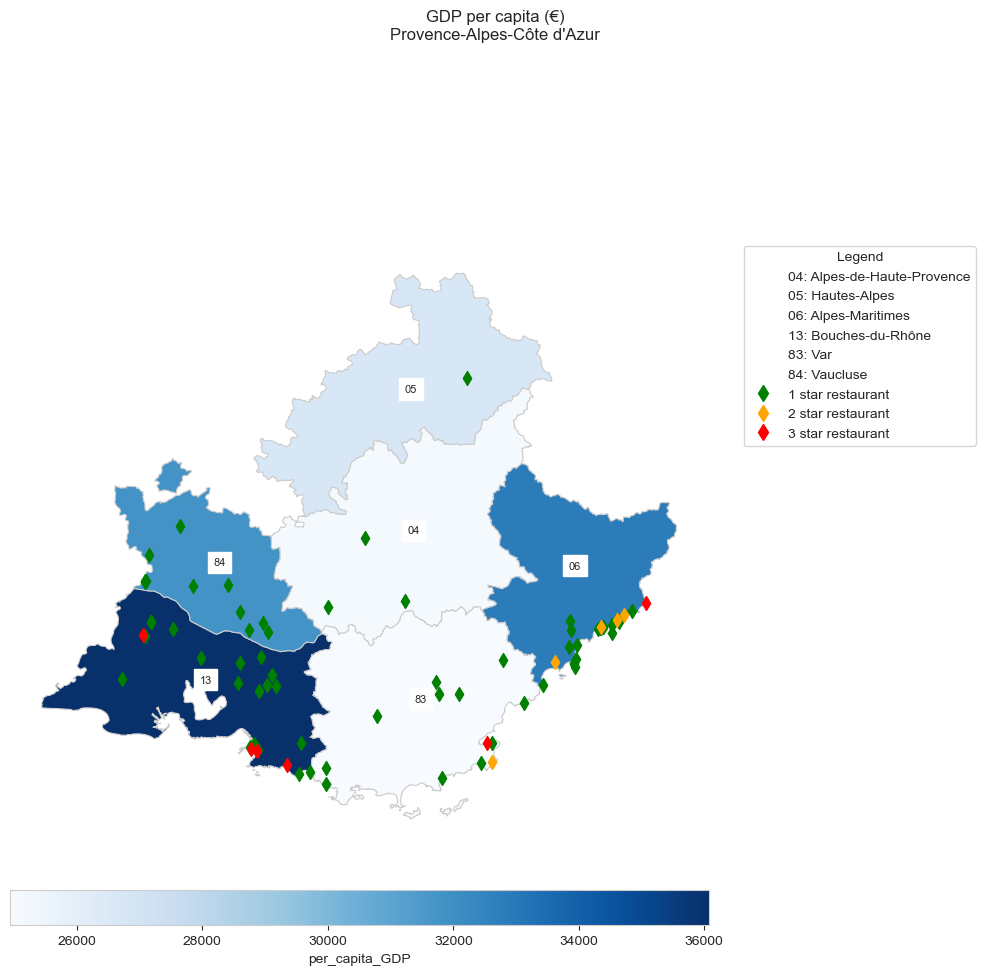

In [35]:
plot_choropleth(paca_dept, 'per_capita_GDP', 'GDP per capita (€)',
                restaurants=True, show_legend=True)

We have seen a moderate positive correlation between `per_capita_GDP` | `poverty_rate` in the PACA region. Unfortunately we cannot explore the spread of this relationship at *arrondissement* level.
 
*Alpes-Maritimes* (06) Michelin star restaurant concentration almost entirely along the coast.

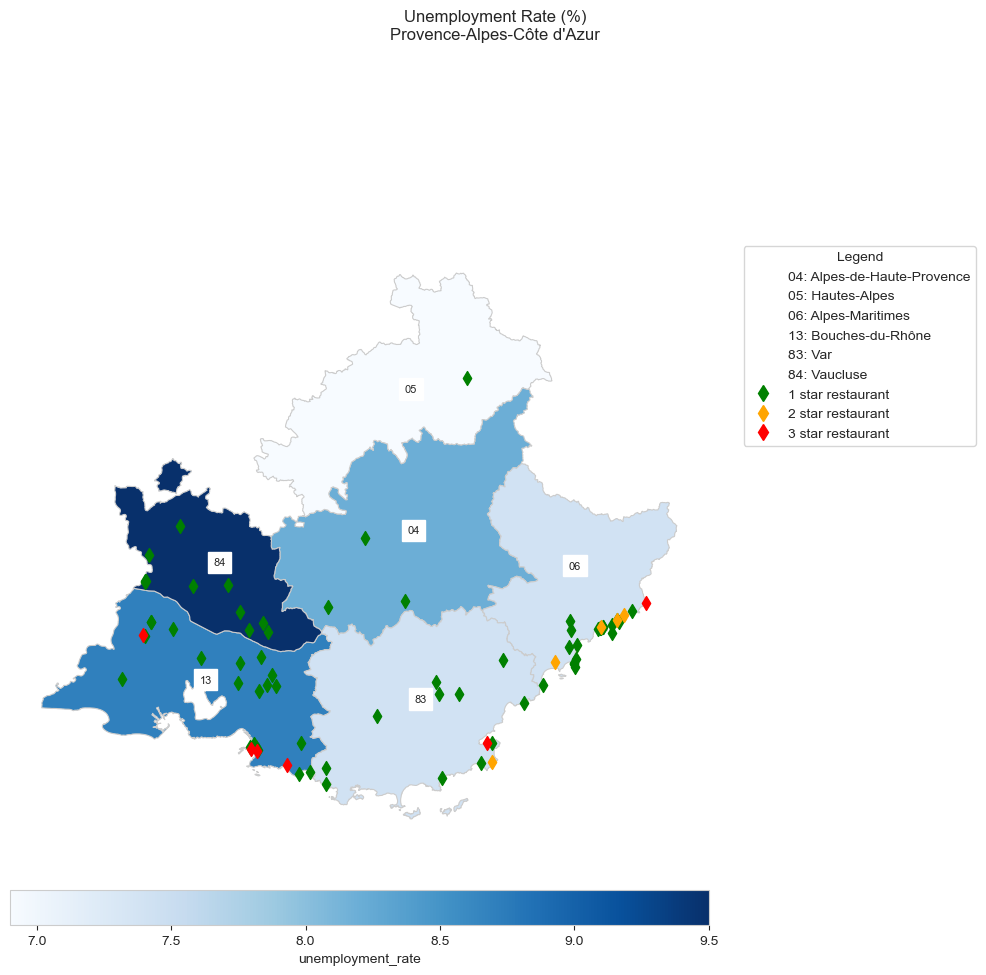

In [36]:
plot_choropleth(paca_dept, 'unemployment_rate', 'Unemployment Rate (%)',
                restaurants=True, show_legend=True)

Bouches-du-Rhône (13) and Vaucluse (84) have the highest `unemployment_rate` in PACA

----
&nbsp;
#### `net_wage` & `poverty_rate` can be compared at both department/arrondissement level

`net_wage`

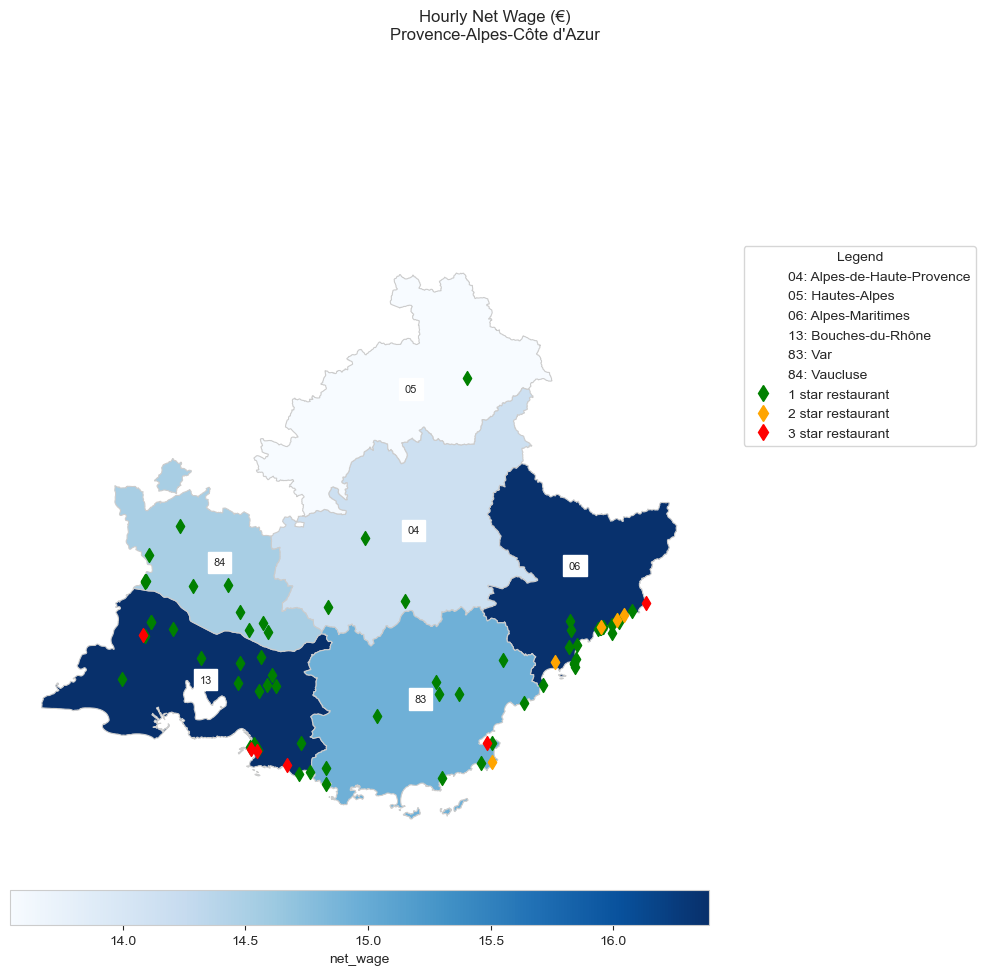

In [51]:
# Department level
plot_choropleth(paca_dept, 'net_wage', 'Hourly Net Wage (€)',
                restaurants=True, show_legend=True)

Bouches-du-Rhône (13) and Alpes-Maritimes (06) have the highest `net_wage` in PACA

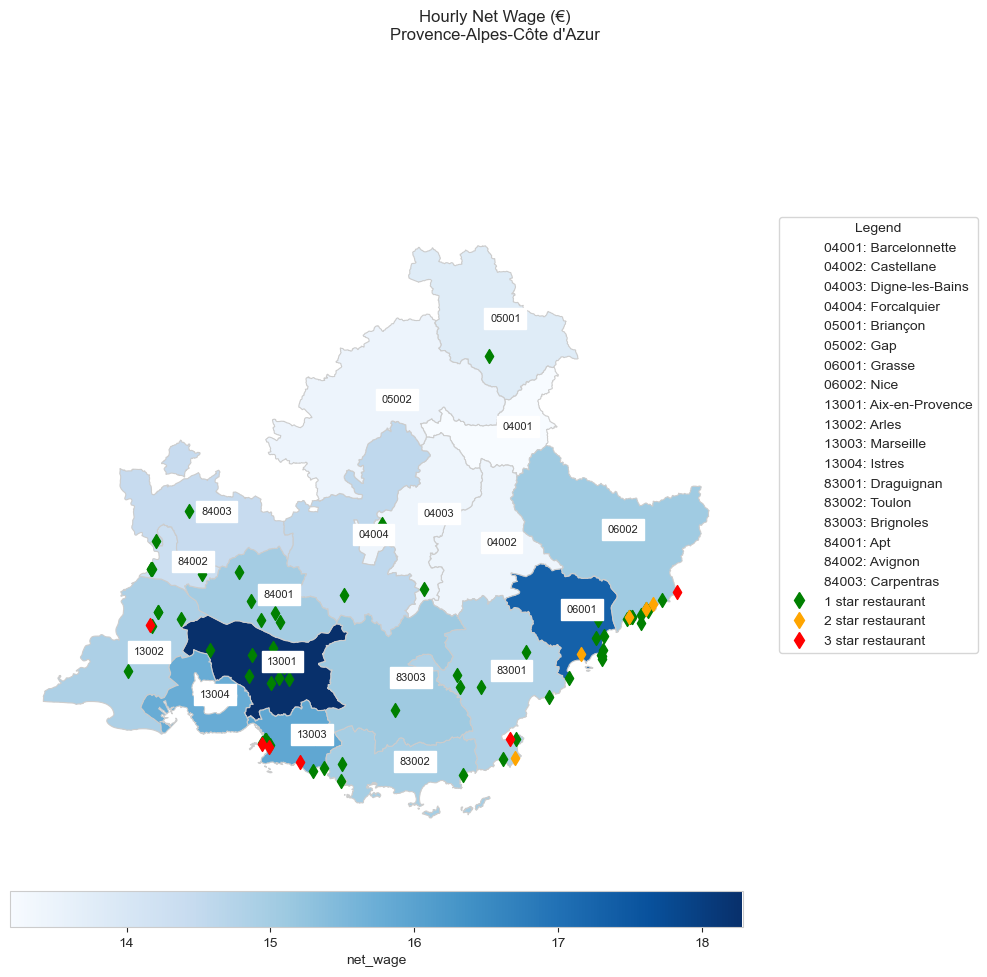

In [55]:
# Arrondissement level
plot_choropleth(paca_arron, 'net_wage', 'Hourly Net Wage (€)',
                granularity='arrondissement', restaurants=True, show_legend=True)

In [54]:
print(f"The average hour net wage in France is {france_wage:.2f}€")

The average hour net wage in France is 16.05€


At arrondissement level, PACA has a low average wage with only *Aix-en-Provence* and *Grasse* above the national average

----
&nbsp;
`poverty_rate`

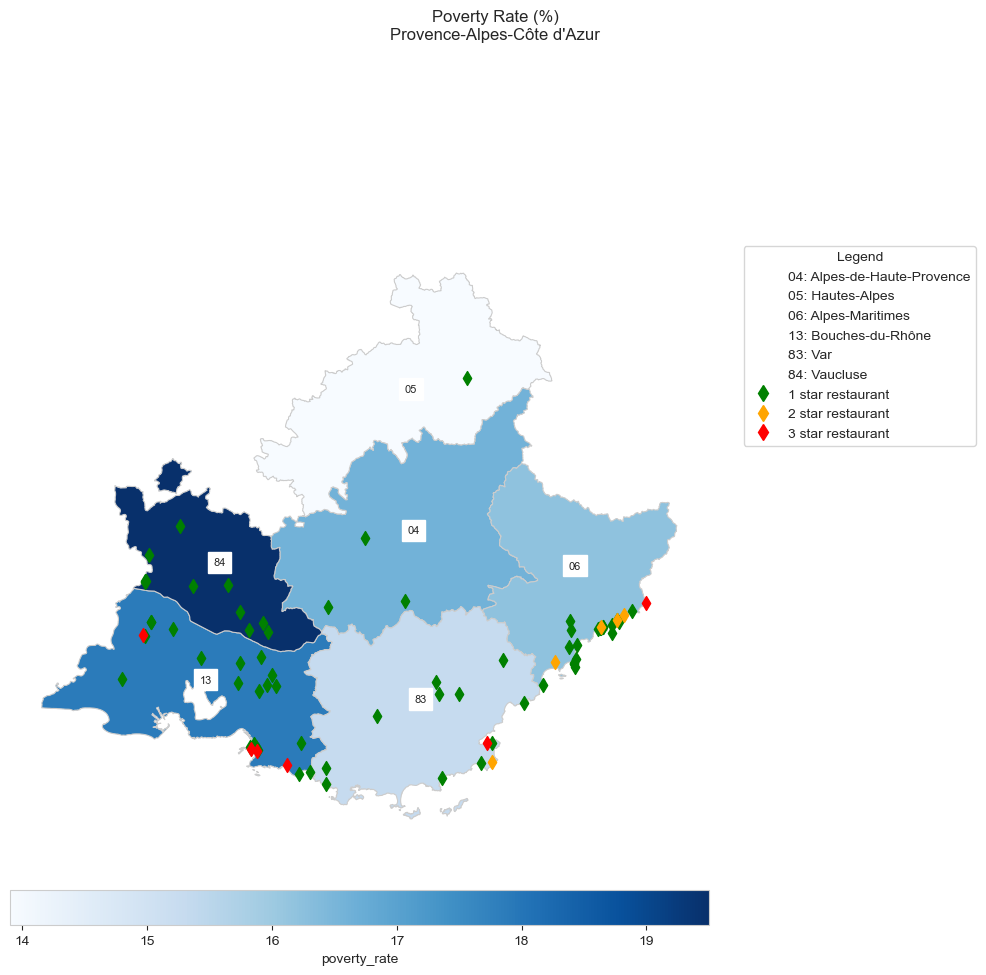

In [37]:
# Department level
lot_choropleth(paca_dept, 'poverty_rate', 'Poverty Rate (%)',
                restaurants=True, show_legend=True)

Vaucluse (84) has the highest `poverty_rate` in PACA

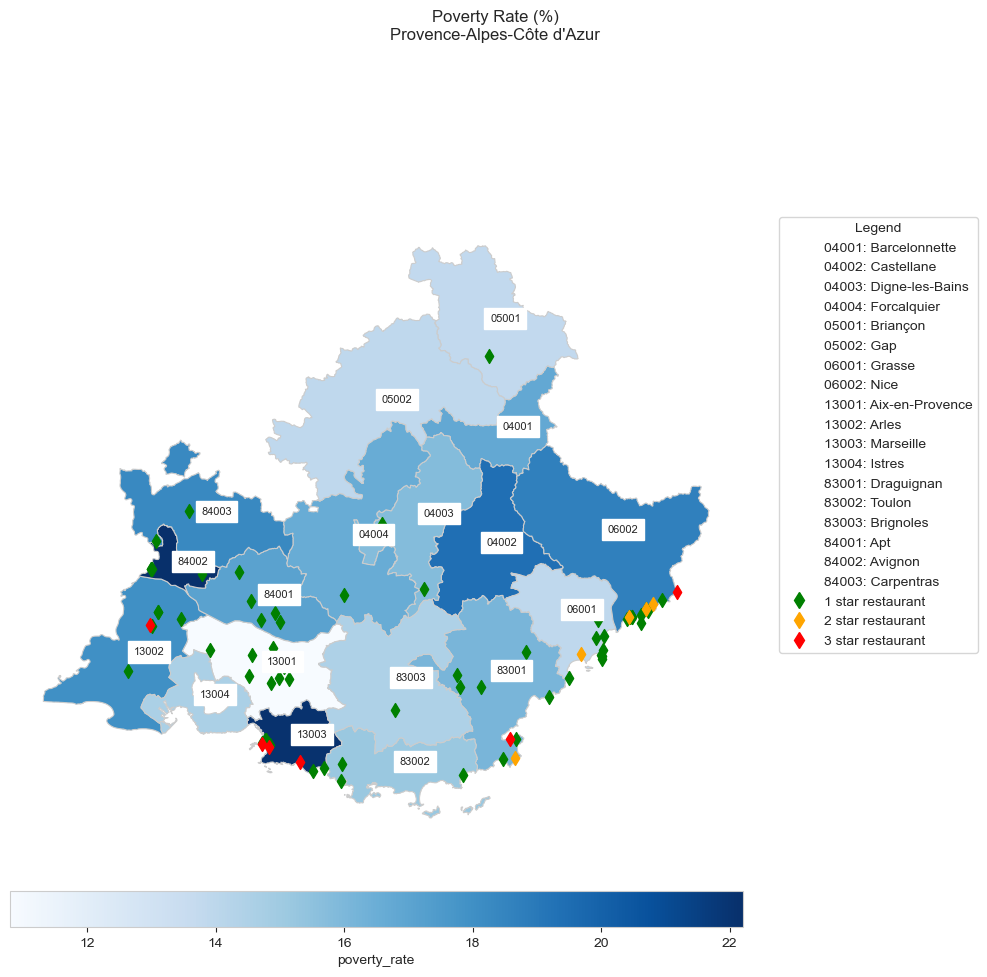

In [38]:
# Arrondissement level
plot_choropleth(paca_arron, 'poverty_rate', 'Poverty Rate (%)', 
                granularity='arrondissement', show_legend=True, restaurants=True)

Marseille and Avignon have the highest `poverty_rate` in PACA. Aix-en-Provence has the lowest

### Comparison of multiple metrics

**`pop_density`**: Provides a visualization of how populated or urbanized certain regions are. This is fundamental as denser areas might have different socio-economic challenges and opportunities than sparser ones.

**`poverty_rate`**: Gives an indication of socio-economic disparities within the regions.

**`net_wage`**: Wages give an idea of the affluence of regions. This, juxtaposed against poverty rates, offers an interesting contrast and can help highlight regions where disparities might be the most pronounced.

In [39]:
cols_of_interest = ['pop_density', 'poverty_rate', 'net_wage']
titles = ['Population Density', 'Poverty Rate (%)', 'Hourly Net Wage (€)']

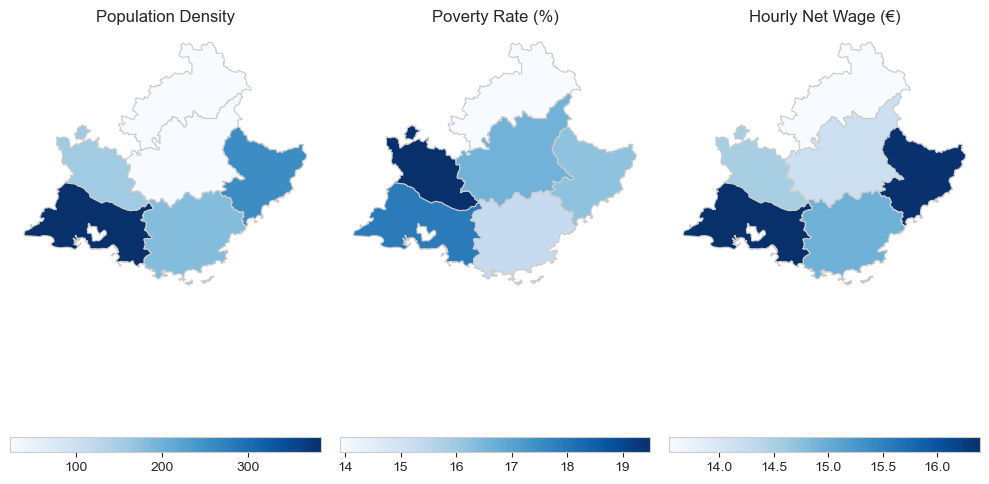

In [40]:
plot_multi_choropleth(paca_dept, cols_of_interest, titles, granularity='department', show_labels=False)

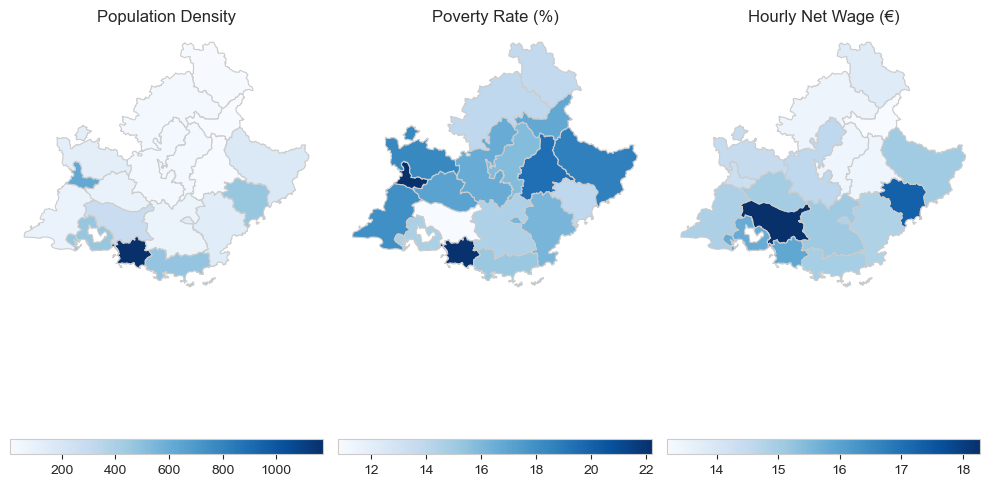

In [41]:
plot_multi_choropleth(paca_arron, cols_of_interest, titles, granularity='arrondissement', show_labels=False)

Marseille is the most densely populated arrondissement in PACA. It also has a high `poverty_rate` comparable to Avignon. 

Grasse and Aix-en-Provence both have relatively low `poverty_rate` and relatively high `net_wage`.

Nice has a reasonably high `poverty_rate` and a comparatively low `net_wage`

In [42]:
outliers = ['nice', 'grasse', 'marseille', 'aix en provence', 'avignon']

----
&nbsp;
### PACA `poverty_rate`, `unemployment_rate`, `net_wage` & `per_capita_GDP` compared to French average


In [43]:
cols_of_interest = ['poverty_rate', 'unemployment_rate', 'net_wage', 'per_capita_GDP']
french_means = {'poverty': france_poverty,
                'unemployment': france_unemployment,
                'wage': france_wage}

#### Departments

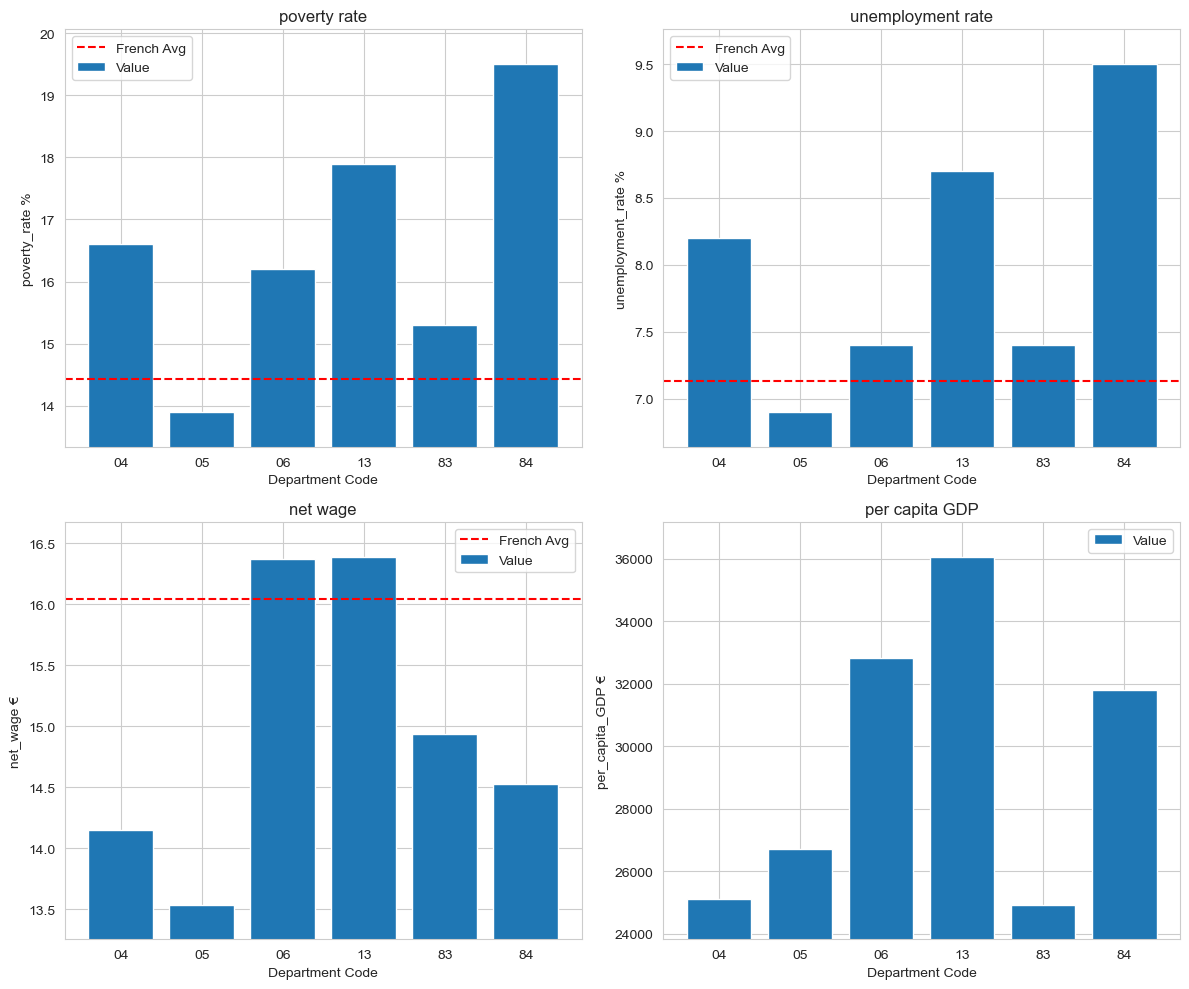

In [44]:
plot_side_by_side(paca_dept, cols_of_interest, french_means)

#### Arrondissements

In [46]:
outlier_paca = filter_dataframe(paca_arron, arrondissements=outliers)

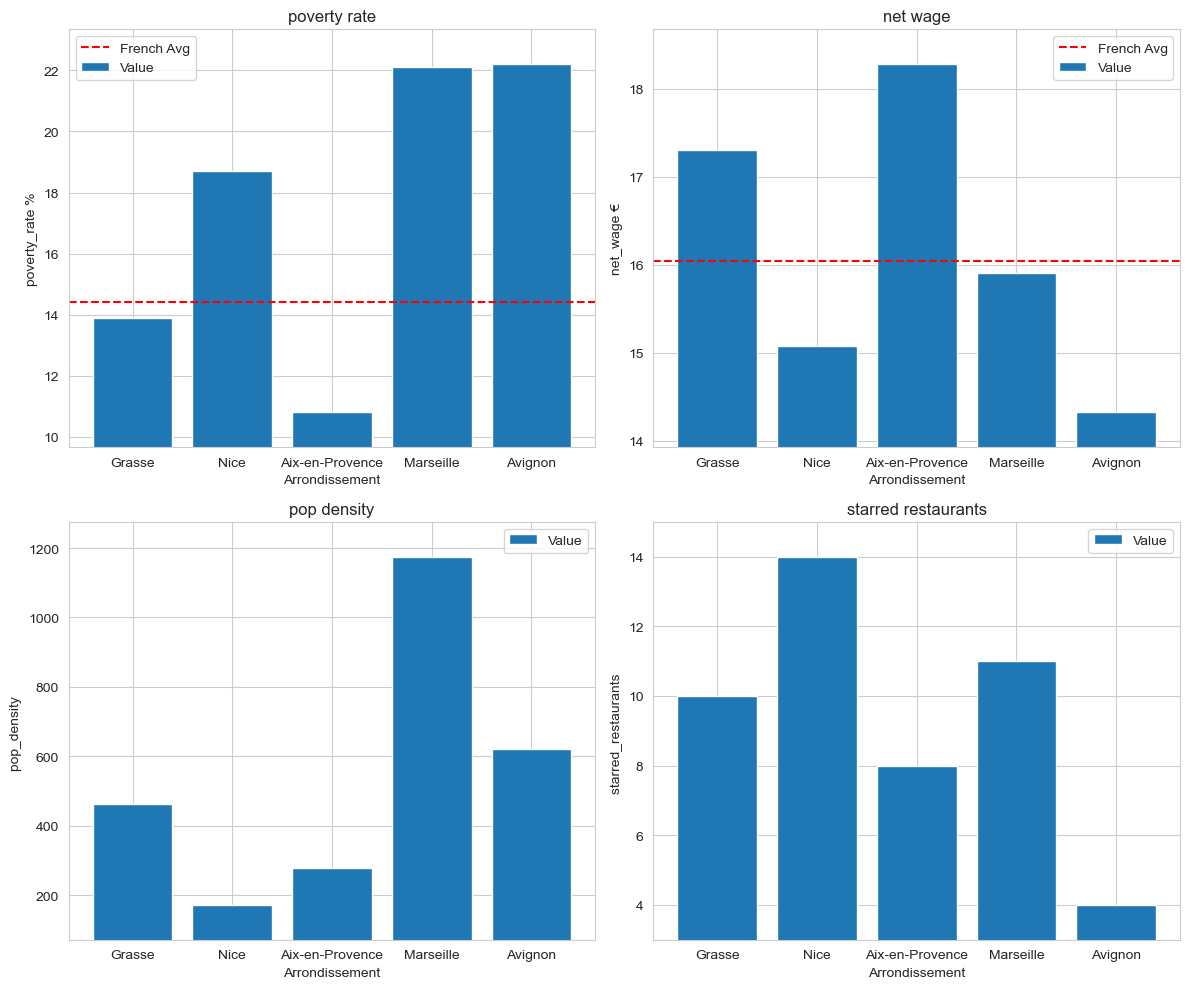

In [48]:
plot_side_by_side(outlier_paca, ['poverty_rate', 'net_wage', 'pop_density', 'starred_restaurants'],
                  french_means, granularity='arrondissement')

----
&nbsp;
## Occitanie

In [49]:
occitanie_dept = filter_dataframe(departments, regions='Occitanie')
dataframe_info(occitanie_dept)

GeoDataFrame.
Unique Regions: 1
Unique Departments: 13

Shape: (13, 20)


code department      capital     region  bib_gourmand  1_star  2_star  \
10   09     Ariège         Foix  Occitanie             2       0       0   
12   11       Aude  Carcassonne  Occitanie             1       3       2   
13   12    Aveyron        Rodez  Occitanie             0       3       1   

    3_star  michelin_stars  starred_restaurants  GDP_millions(€)  \
10       0               0                    0          3261.10   
12       1              10                    6          8292.59   
13       0               5                    4          7181.67   

    per_capita_GDP  poverty_rate  unemployment_rate  net_wage  \
10        21182.30          17.9                9.4     13.37   
12        22100.78          20.0               10.1     13.33   
13        25689.74          14.0                5.7     13.47   

    municipal_population  pop_density  area(sq_km)  \
10              153954.0         31.5      4887.43   
12              375217.0         61.1      6141.03   
13              279554.0         32.0      8736.06   

                                            locations  \
10  {'Bib': [[43.0027665, 1.1373639], [43.0612879,...   
12  {'Bib': [[43.0891229, 2.6196977]], '1': [[43.2...   
13  {'Bib': None, '1': [[44.47275, 2.71992], [44.2...   

                                             geometry  
10  POLYGON ((1.68842 43.27355, 1.69139 43.27173, ...  
12  POLYGON ((1.68842 43.27355, 1.69029 43.27437, ...  
13  POLYGON ((2.20748 44.61553, 2.20885 44.61631, ...

In [50]:
occitanie_arron = filter_dataframe(arrondissements, regions='Occitanie')
dataframe_info(occitanie_arron)

GeoDataFrame.
Unique Regions: 1
Unique Departments: 13
Unique Arrondissements: 36

Shape: (36, 18)


code arrondissement department_num department capital     region  \
27  09001           Foix             09     Ariège    Foix  Occitanie   
28  09002        Pamiers             09     Ariège    Foix  Occitanie   
29  09003   Saint-Girons             09     Ariège    Foix  Occitanie   

    bib_gourmand  1_star  2_star  3_star  michelin_stars  starred_restaurants  \
27             0       0       0       0               0                    0   
28             1       0       0       0               0                    0   
29             1       0       0       0               0                    0   

    municipal_population  pop_density  poverty_rate  net_wage  \
27                 47592         26.5          15.3     13.55   
28                 65324         60.7          17.3     13.31   
29                 41038         20.3          22.0     13.21   

                            locations  \
27  {'1': None, '2': None, '3': None}   
28  {'1': None, '2': None, '3': None}   
29  {'1': None, '2': None, '3': None}   

                                             geometry  
27  POLYGON ((1.49886 43.09493, 1.50194 43.09495, ...  
28  POLYGON ((1.49886 43.09493, 1.49470 43.09792, ...  
29  POLYGON ((1.05354 43.14545, 1.05891 43.14183, ...

----
&nbsp;
### Choropleth maps

Missing at *arrondissement* level, we visualise `GDP_per_capita` & `unemployment_rate` across Occitanie along with any michelin starred restaurants

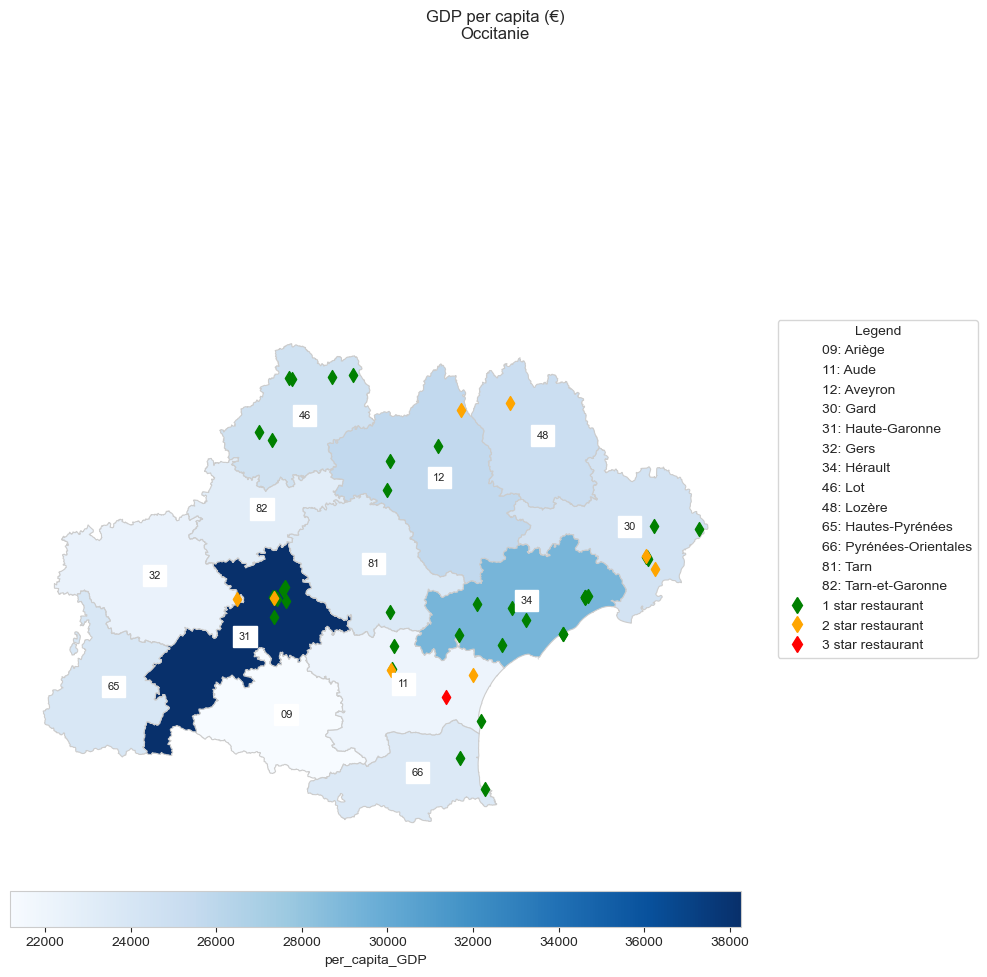

In [66]:
plot_choropleth(occitanie_dept, 'per_capita_GDP', 'GDP per capita (€)',
                restaurants=True, show_legend=True)

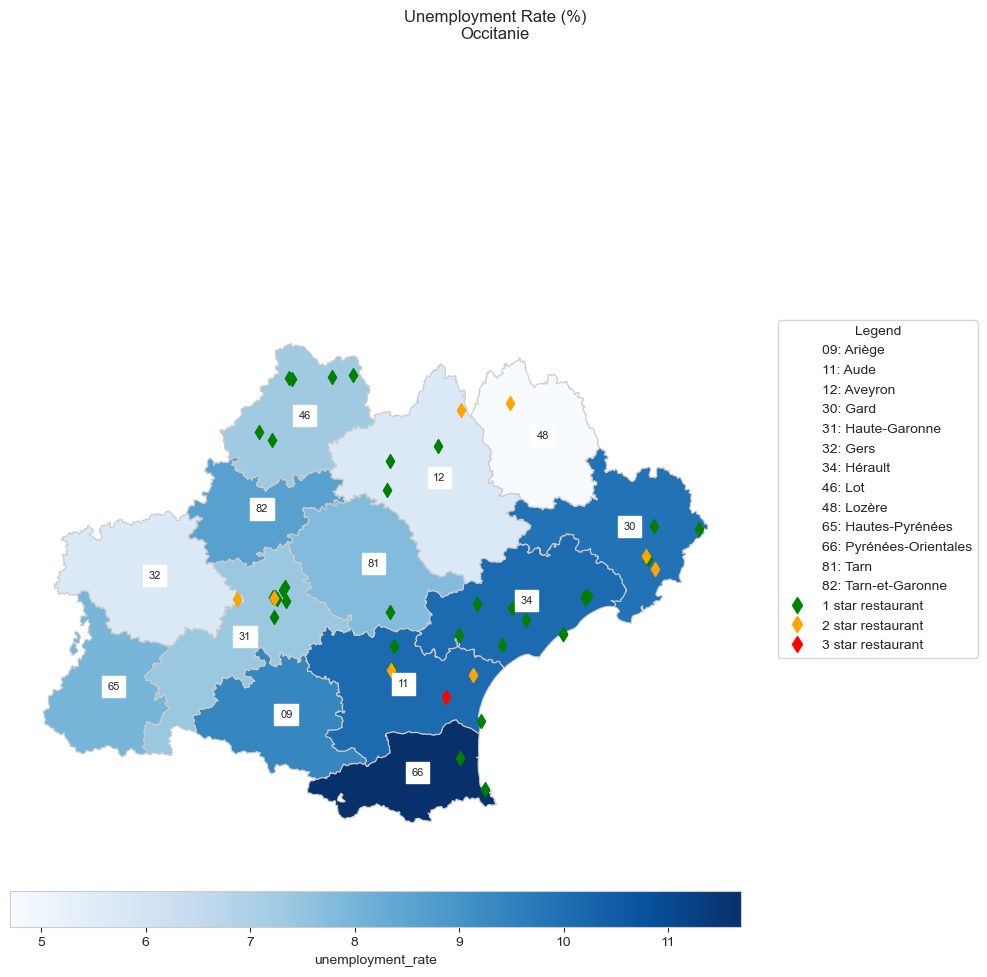

In [67]:
plot_choropleth(occitanie_dept, 'unemployment_rate', 'Unemployment Rate (%)',
                restaurants=True, show_legend=True)

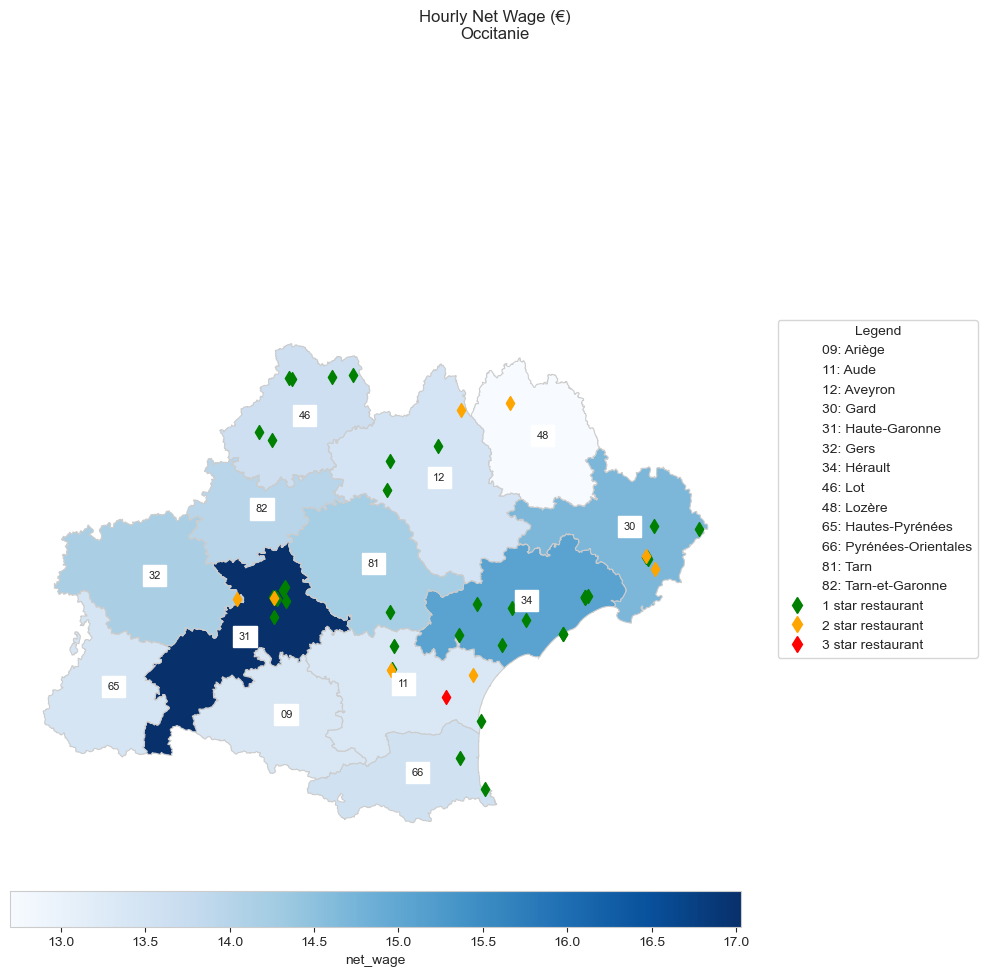

In [68]:
plot_choropleth(occitanie_dept, 'net_wage', 'Hourly Net Wage (€)',
                restaurants=True, show_legend=True)

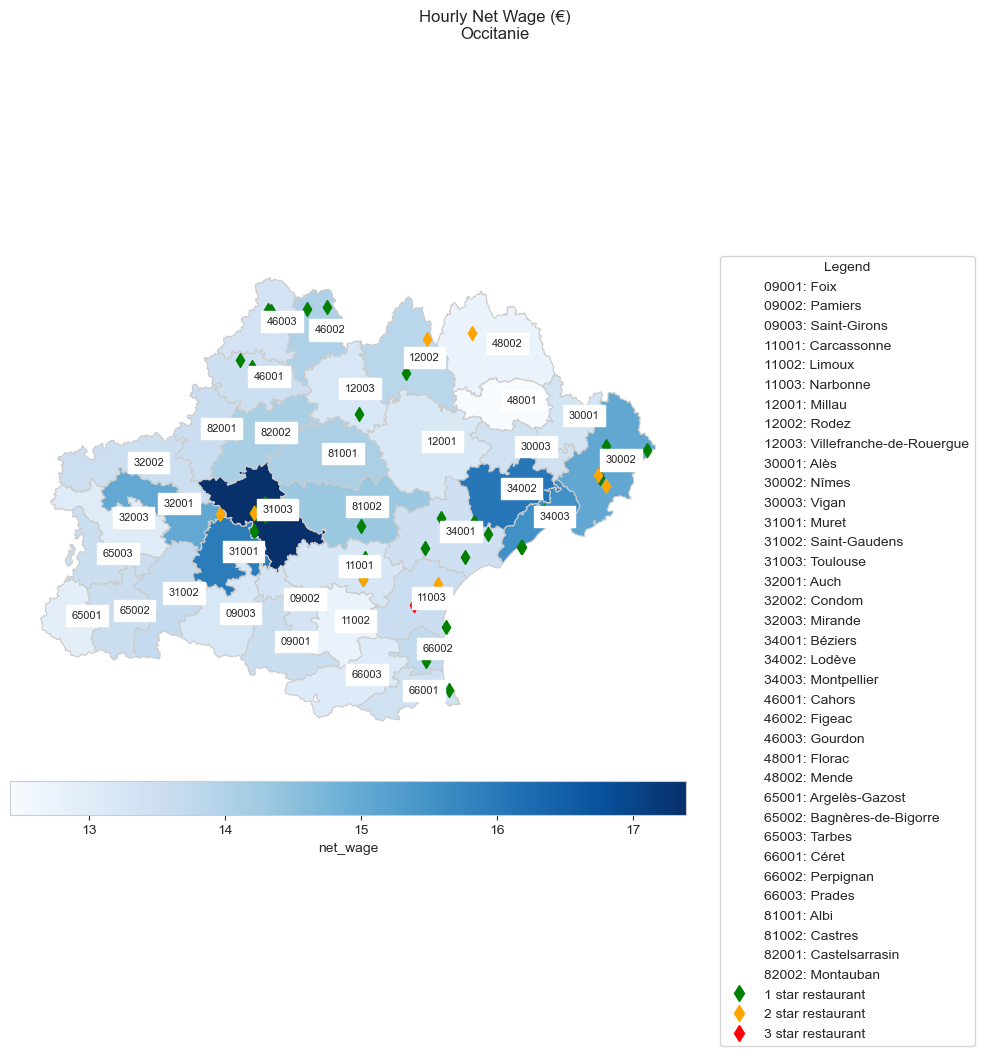

In [72]:
plot_choropleth(occitanie_arron, 'net_wage', 'Hourly Net Wage (€)',
                granularity='arrondissement', restaurants=True, show_legend=True)

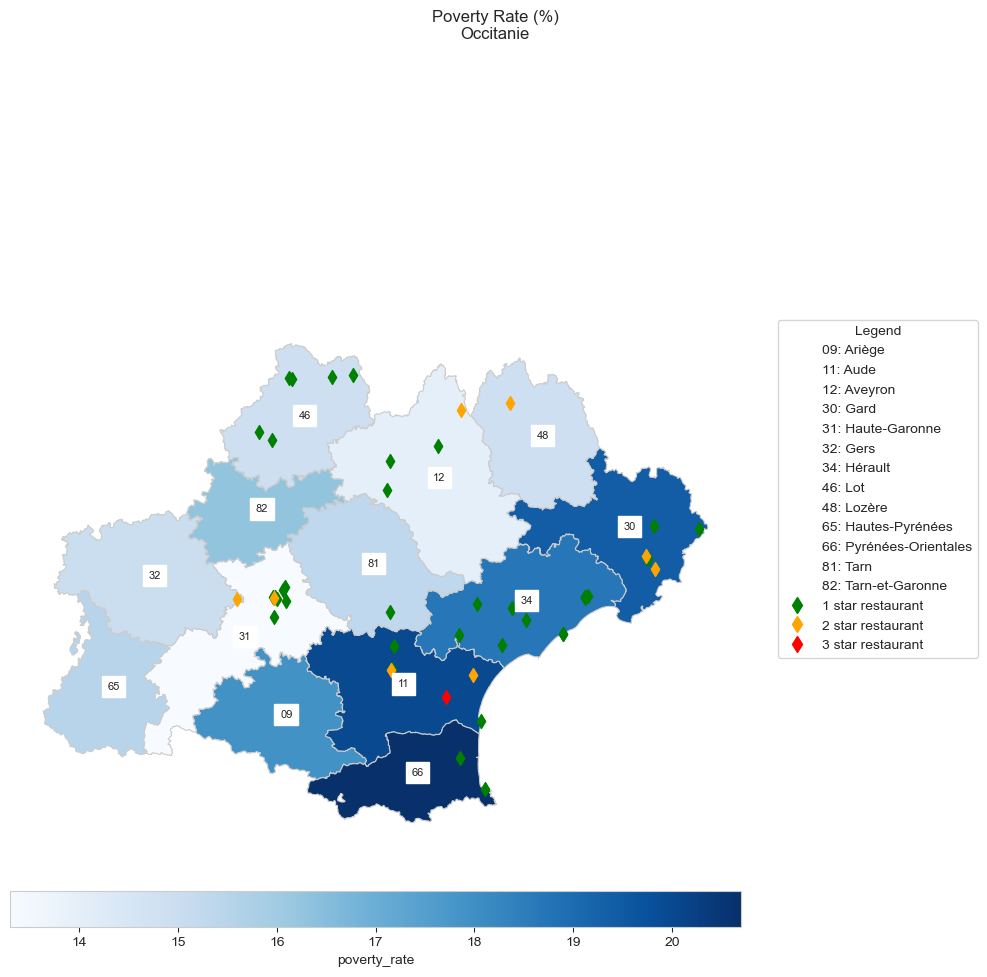

In [73]:
plot_choropleth(occitanie_dept, 'poverty_rate', 'Poverty Rate (%)',
                restaurants=True, show_legend=True)

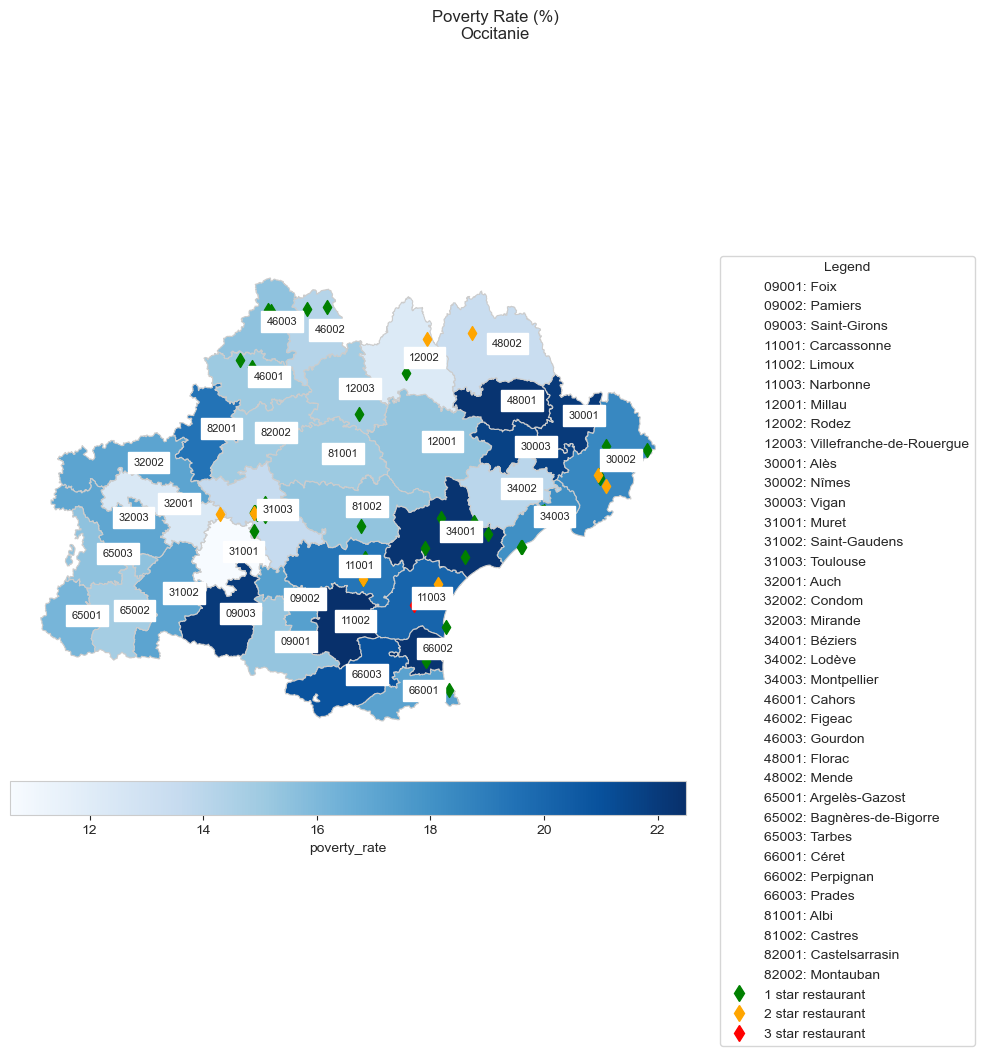

In [74]:
plot_choropleth(occitanie_arron, 'poverty_rate', 'Poverty Rate (%)',
                granularity='arrondissement', show_legend=True, restaurants=True)

----
&nbsp;
## Partitioning PACA & Occitanie into 'Mediterranean' departments

In [117]:
cols_of_interest = ['per_capita_GDP', 'poverty_rate', 'net_wage', 'unemployment_rate']
titles = ['GDP_per_capita (€)', 'Poverty Rate (%)', 'Hourly Net Wage (€)', 'Unemployment Rate']

We view the entirety of the South of France and notice the 'Mediterranean departments' have the classic markers of economics distress, 

- Low `GDP_per_capita`
- High `poverty_rate`
- Low `net_wage`
- High `unemployment_rate`

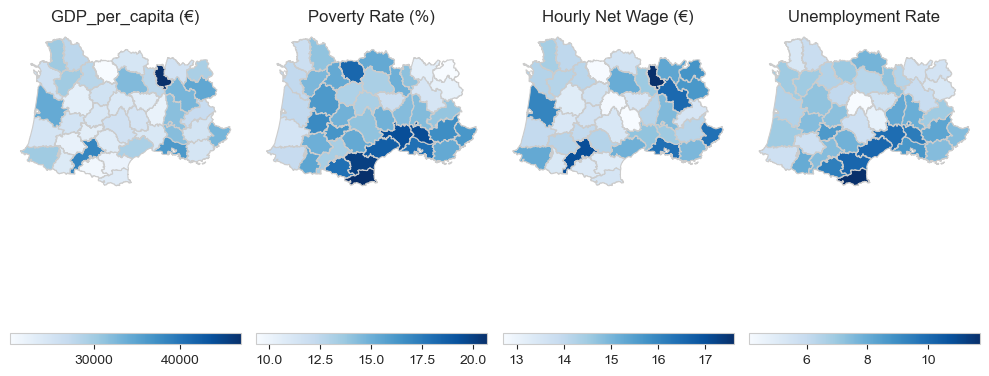

In [119]:
plot_multi_choropleth(south_dept, cols_of_interest, titles, granularity='department', show_labels=False)

Excluding Alpes-Maritimes (06) & Var (83)

In [120]:
med_depts = ['gard', 'aude', 'herault', 'pyrennes orientales', 'bouches du rhone', 'vaucluse']

In [121]:
med_dept = filter_dataframe(dept_short, departments=med_depts)
med_arron = filter_dataframe(arron_short, departments=med_depts)

Compared together there is a degree of variation

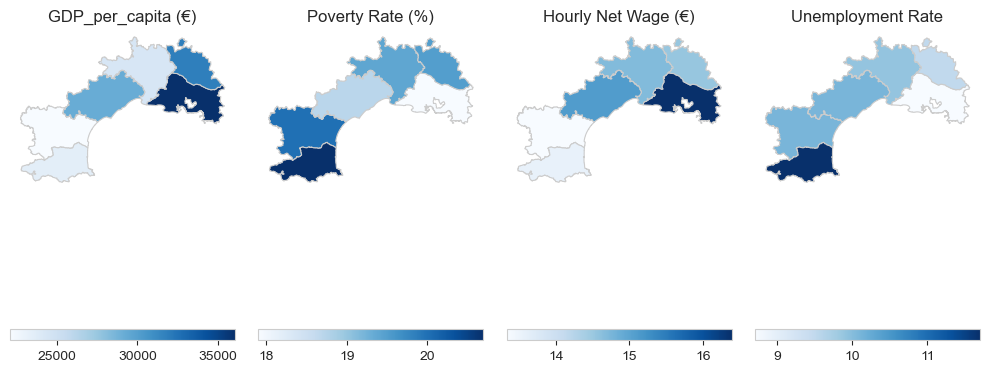

In [122]:
plot_multi_choropleth(med_dept, cols_of_interest, titles, granularity='department', show_labels=False)

----
&nbsp;
### Department level

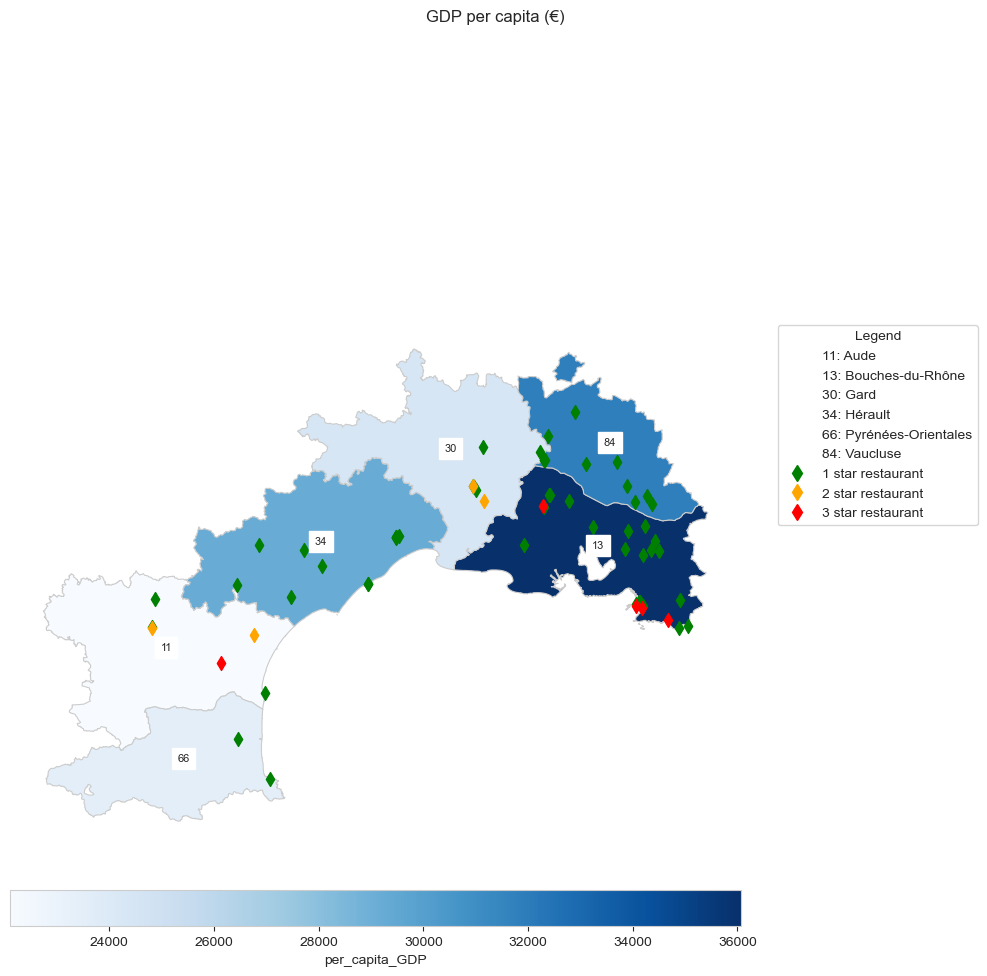

In [105]:
plot_choropleth(med_dept, 'per_capita_GDP', 'GDP per capita (€)',
                restaurants=True, show_legend=True)

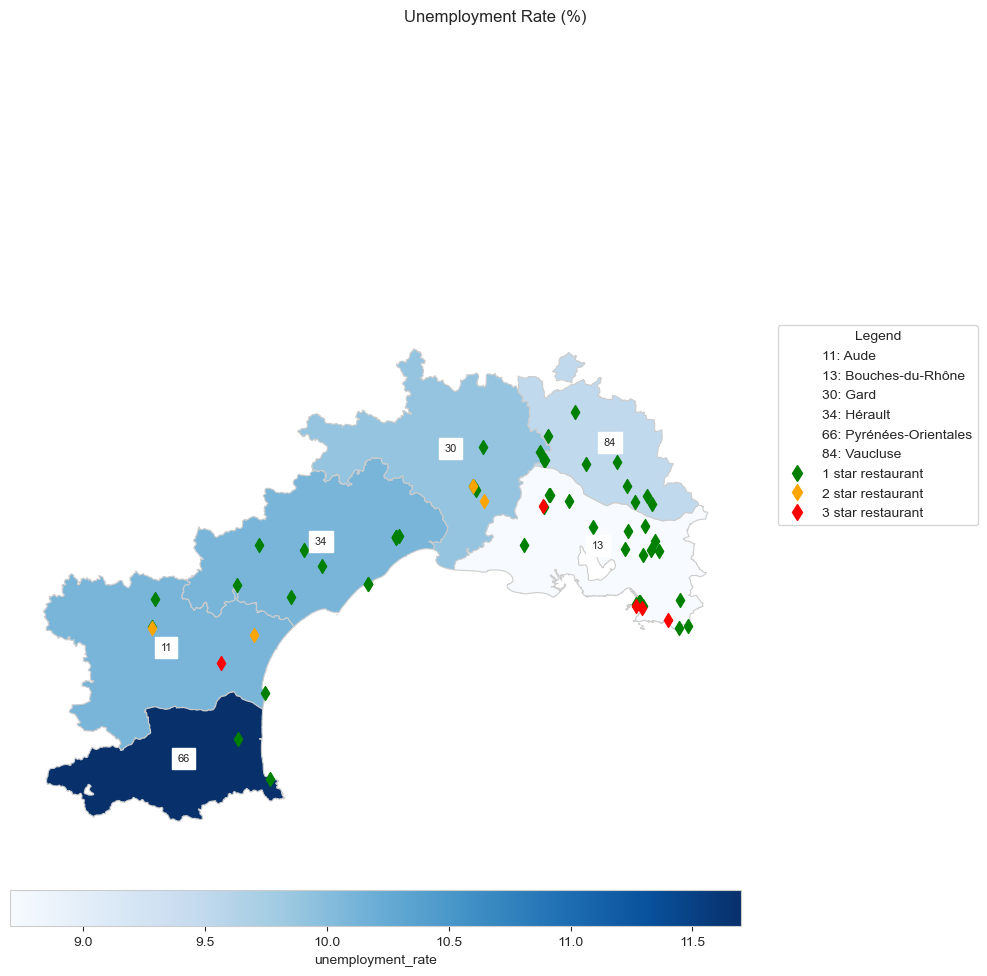

In [106]:
plot_choropleth(med_dept, 'unemployment_rate', 'Unemployment Rate (%)',
                restaurants=True, show_legend=True)

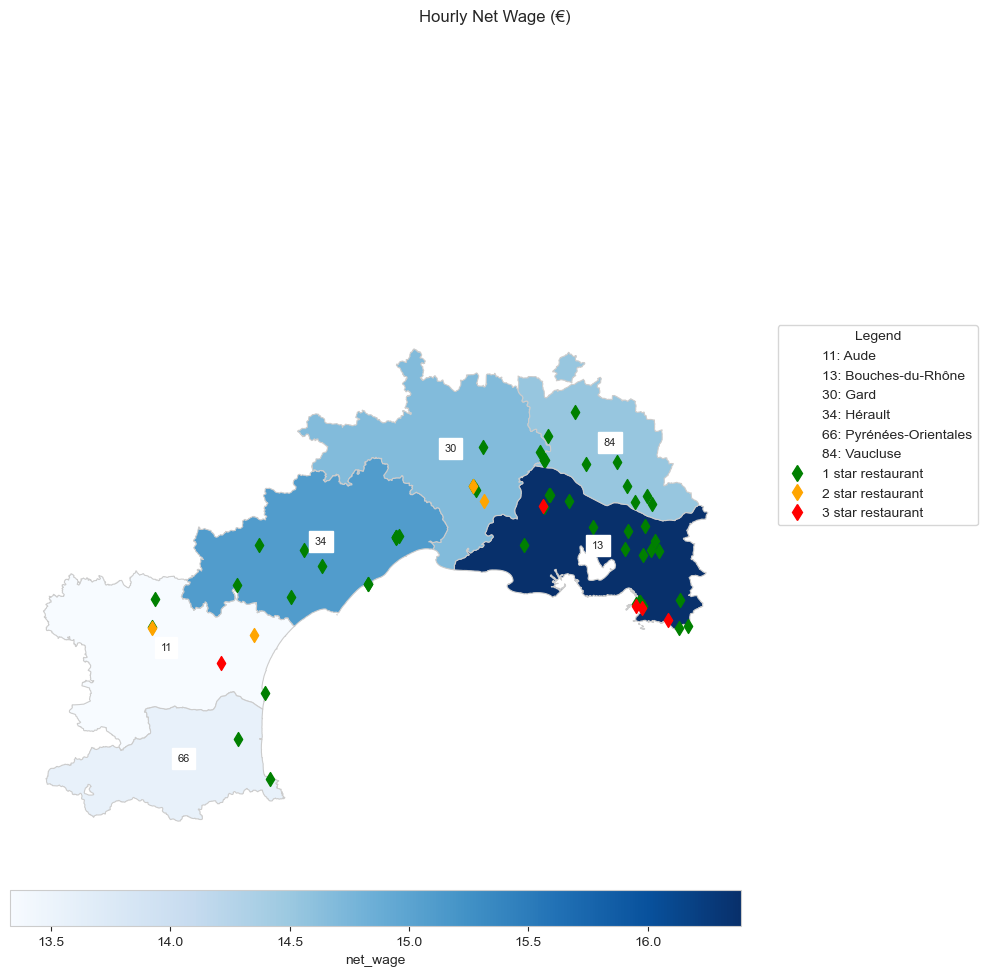

In [107]:
plot_choropleth(med_dept, 'net_wage', 'Hourly Net Wage (€)',
                restaurants=True, show_legend=True)

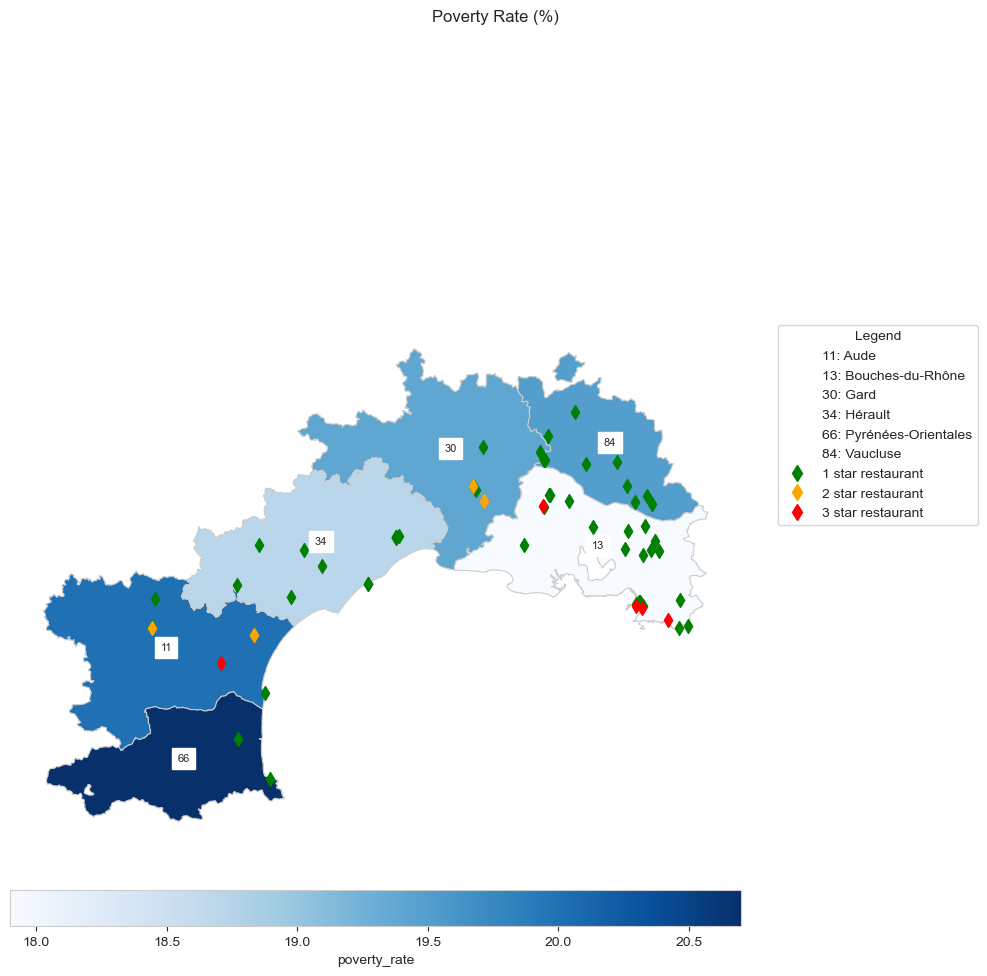

In [108]:
plot_choropleth(med_dept, 'poverty_rate', 'Poverty Rate (%)',
                restaurants=True, show_legend=True)

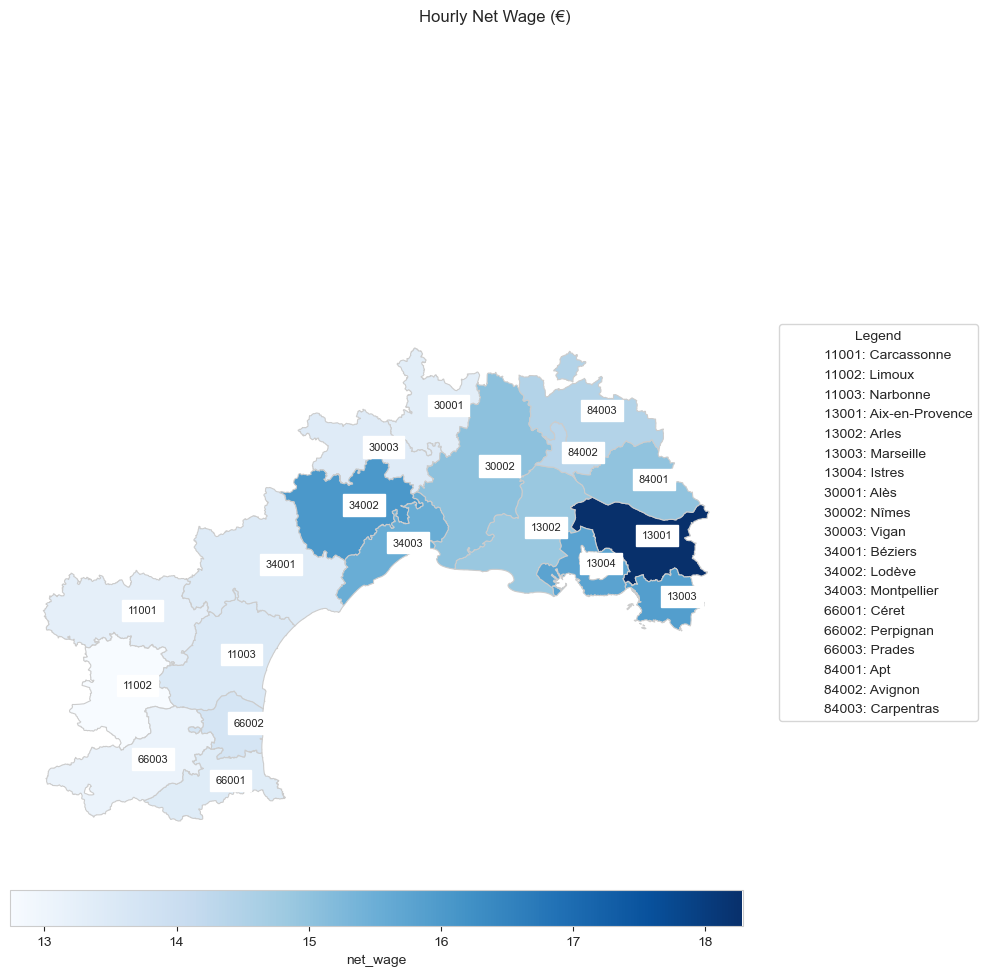

In [109]:
plot_choropleth(med_arron, 'net_wage', 'Hourly Net Wage (€)',
                granularity='arrondissement', restaurants=False, show_legend=True)

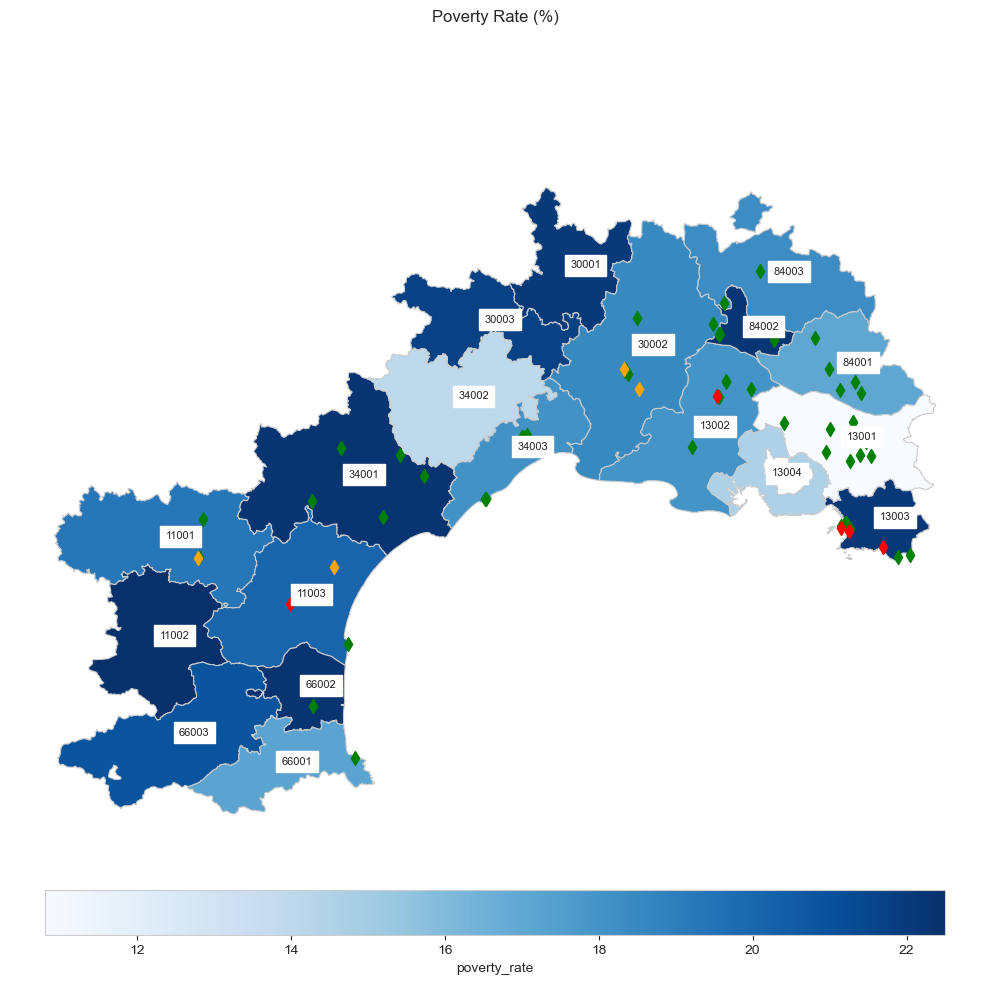

In [110]:
plot_choropleth(med_arron, 'poverty_rate', 'Poverty Rate (%)',
                granularity='arrondissement', show_legend=False, restaurants=True)